In [21]:
#import des libraires nécessaires
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from brainspace.mesh.mesh_io import read_surface
from brainspace.plotting import plot_hemispheres
import pandas as pd
import seaborn as sns
from scipy.stats import ttest_ind
import statsmodels.api as sm
import glob
import plotly.graph_objects as go
from scipy.stats import chi2_contingency
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
import laBIBILaRORO as lbr
from importlib import reload
#reload(laBIBILaRORO)
from itertools import combinations
#! pip install pingouin
import pingouin as pg
from scipy.stats import f_oneway
from scipy.stats import pearsonr
import re
from scipy.stats import zscore
%matplotlib inline
from IPython.display import display,Image
from scipy.stats import chi2_contingency

from scipy.stats import pearsonr
from sklearn.metrics import explained_variance_score
import pingouin as pg

from brainstat.datasets import fetch_mask, fetch_template_surface,fetch_parcellation
from brainspace.mesh.mesh_io import read_surface
from brainstat.stats.SLM import SLM
from brainstat.stats.terms import FixedEffect,MixedEffect
from itertools import chain


In [6]:
#glasser = fetch_parcellation("fsaverage5", "glasser", 360)
#pial_left, pial_right = fetch_template_surface("fsaverage5",layer="pial",join=False)
#inflated_left, inflated_right = fetch_template_surface("fsaverage5",layer="inflated",join=False)
#pial_combined = fetch_template_surface("fsaverage5", join=True)
#pial_combined_fslr32k = fetch_template_surface("fslr32k", join=True)
#pial_left_fslr32k, pial_right_fslr32k = fetch_template_surface("fslr32k", join=False)
#inflated_left_fslr32k,inflated_right_fslr32k = fetch_template_surface("fslr32k",layer="inflated", join=False)
#mask = fetch_mask("fsaverage5")

pial_left, pial_right = fetch_template_surface("fsaverage5",layer="pial",join=False)
inflated_left, inflated_right = fetch_template_surface("fsaverage5",layer="inflated",join=False)
pial_combined = fetch_template_surface("fsaverage5", join=True)
mask = fetch_mask("fsaverage5")
glasser = fetch_parcellation("fsaverage5", "glasser", 360)

pial_left_fslr32k, pial_right_fslr32k = fetch_template_surface("fslr32k", join=False)
inflated_left_fslr32k,inflated_right_fslr32k = fetch_template_surface("fslr32k",layer="inflated", join=False)
vinflated_left_fslr32k,vinflated_right_fslr32k = fetch_template_surface("fslr32k",layer="vinflated", join=False)
pial_combined_fslr32k = fetch_template_surface("fslr32k", join=True)
mask_fslr32k = fetch_mask("fslr32k")
glasser_fslr32k = fetch_parcellation("fslr32k", "glasser", 360)

In [7]:
palette = {
    'bvFTD': '#1f77b4',  # Bleu
    'PPD': '#ff7f0e',  # Orange
    'ADS': '#2ca02c',   # Vert
    'BPD': '#d62728'     # Rouge
}

In [8]:
# Obtenir les couleurs de la colormap 'tab10'
tab10_colors = plt.get_cmap('tab10').colors

# Fonction pour convertir une couleur RGB en code d'échappement ANSI
def rgb_to_ansi(r, g, b):
    return f'\033[38;2;{int(r*255)};{int(g*255)};{int(b*255)}m'

# Convertir les couleurs en codes d'échappement ANSI
ansi_colors = [rgb_to_ansi(*color) for color in tab10_colors]

In [9]:
print(f"La surface utilisée est fsaverage5 avec {pial_combined.GetNumberOfPoints()} points")
print(f"tandis que la fsaverage standard comporte {pial_combined_fslr32k.GetNumberOfPoints()} points")

La surface utilisée est fsaverage5 avec 20484 points
tandis que la fsaverage standard comporte 64984 points


In [10]:
#Chemin 
STUDY_PATH=os.path.join("/NAS","dumbo","protocoles","PSY_bvFTD")
DERIVATIVE_DIR1=os.path.join(STUDY_PATH,"data","bids","derivatives")
DERIVATIVE_DIR2=os.path.join("/NAS","deathrow","renaud","MRI_INSCD_maximeBertoux","bids","derivatives")

In [11]:
clinical_data = pd.read_excel(os.path.join(STUDY_PATH,"ETUDES_24092024.xlsx"))#1082024.xlsx"))
print(f"patients : {len(clinical_data)}")

etude1=clinical_data[clinical_data['ETUDE1_IRM']=='oui']
print(f"pts in the study 1 {len(etude1)}")

# Supprimer les lignes où la colonne 'GROUPE' est égale à 'Control'
df_filtered = etude1[etude1['GROUPE'] != 'Control']
print(f"nb pts witout controls : {len(df_filtered)}")


patients : 104
pts in the study 1 83
nb pts witout controls : 83


In [12]:
scanner_data = pd.read_excel(os.path.join(STUDY_PATH,'BDD_Imagerie_Etude_Neuropsy_ProfileJD.xlsx'))
# Effectuer la jointure sur la colonne 'Nom'
merged_data = df_filtered.merge(scanner_data[['Nom', 'MagneticFieldStrength']], on='Nom', how='left')
merged_data.set_index("ID_IRM", inplace=True)
# Afficher le DataFrame résultant avec la colonne 'MagneticFieldStrength'
print(merged_data[['Nom', 'MagneticFieldStrength']])

               Nom  MagneticFieldStrength
ID_IRM                                   
PSY006   BLANCHARD                    1.5
PSY001  BAILLOEUIL                    3.0
PSY011     BUISINE                    NaN
PSY005      BILLON                    3.0
PSY113      BOULET                    1.5
...            ...                    ...
PSY109     ROSTANE                    NaN
PSY087       READY                    NaN
PSY110  SAINT OMER                    NaN
PSY088   SOUILLART                    1.5
PSY089       TOREL                    3.0

[83 rows x 2 columns]


In [13]:
for groupUsed in ['GROUPE', 'SOUS_GROUPE']:
    # Créer une table de contingence pour MagneticFieldStrength et le groupe utilisé
    contingency_table = pd.pivot_table(merged_data, values="DDN", columns='MagneticFieldStrength', index=groupUsed, aggfunc='count', fill_value=0)

    # Afficher la table de contingence
    print(f"Table de contingence pour {groupUsed}:")
    print(contingency_table)

    # Effectuer le test du chi-carré
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    # Afficher les résultats du test du chi-carré
    print(f"\nRésultats du test du chi-carré pour {groupUsed}:")
    print(f"Chi2: {chi2}")
    print(f"p-value: {p}")
    print(f"Degrees of freedom: {dof}")
    print("Expected frequencies:")
    print(expected)

    # Vérifier s'il y a une différence significative
    if p < 0.05:
        print(f"\nIl y a une différence significative entre les groupes {groupUsed} (p < 0.05).")
    else:
        print(f"\nIl n'y a pas de différence significative entre les groupes {groupUsed} (p >= 0.05).")

Table de contingence pour GROUPE:
MagneticFieldStrength  1.5  3.0
GROUPE                         
PPD                     11   14
bvFTD                   19   23

Résultats du test du chi-carré pour GROUPE:
Chi2: 0.0
p-value: 1.0
Degrees of freedom: 1
Expected frequencies:
[[11.19402985 13.80597015]
 [18.80597015 23.19402985]]

Il n'y a pas de différence significative entre les groupes GROUPE (p >= 0.05).
Table de contingence pour SOUS_GROUPE:
MagneticFieldStrength  1.5  3.0
SOUS_GROUPE                    
ADS                      4    7
BPD                      5    5
bvFTD                   19   23

Résultats du test du chi-carré pour SOUS_GROUPE:
Chi2: 0.42662337662337674
p-value: 0.8079042836464447
Degrees of freedom: 2
Expected frequencies:
[[ 4.88888889  6.11111111]
 [ 4.44444444  5.55555556]
 [18.66666667 23.33333333]]

Il n'y a pas de différence significative entre les groupes SOUS_GROUPE (p >= 0.05).


In [14]:
#valCT = []
subj2drop=[]
valCT = {f"sm_{smoothing_fwhm}": [] for smoothing_fwhm in chain([11], range(15, 31, 5))}
for smoothing_fwhm in chain([11], range(15, 31, 5)):
    print(f"Smoothing   FWHM: {smoothing_fwhm} mm")
    for elt in merged_data.index:
        sub = f"sub-{str(elt)}"
        if elt.startswith("PSY"):
            path_file_lh = os.path.join(DERIVATIVE_DIR1, "micapipe_v0.2.0", sub, "ses-1", "maps", sub + f"_ses-1_hemi-L_surf-fsaverage5_label-thickness_sm{smoothing_fwhm}.func.gii")
            path_file_rh = os.path.join(DERIVATIVE_DIR1, "micapipe_v0.2.0", sub, "ses-1", "maps", sub + f"_ses-1_hemi-R_surf-fsaverage5_label-thickness_sm{smoothing_fwhm}.func.gii")
        #else:
        #    path_file_lh = os.path.join(DERIVATIVE_DIR2, "micapipe_v0.2.0", sub, "ses-1", "maps", sub + "_ses-1_hemi-L_surf-fsaverage5_label-thickness_sm11.func.gii")
        #    path_file_rh = os.path.join(DERIVATIVE_DIR2, "micapipe_v0.2.0", sub, "ses-1", "maps", sub + "_ses-1_hemi-R_surf-fsaverage5_label-thickness_sm11.func.gii")
        
        if os.path.exists(path_file_lh) and os.path.exists(path_file_rh):
            #date_bnp = merged_data.loc[elt, 'Date_IRM_Proche_BNP']
            #date_gremots = merged_data.loc[elt, 'Date_IRM_Proche_GREMOTS']
            #if pd.notna(date_bnp) and pd.notna(date_gremots) and date_bnp != date_gremots:
            #    print(f"Index: {elt}")
            #    print(f"Date_IRM_Proche_BNP: {date_bnp}")
            #    print(f"Date_IRM_Proche_GREMOTS: {date_gremots}")
            
            # Uncomment the following lines if you need to load and process the files
            tmp_rh = nib.load(path_file_rh) 
            tmp_lh = nib.load(path_file_lh)
            volumeG1 = np.concatenate([tmp_lh.darrays[0].data, tmp_rh.darrays[0].data], axis=0)
            valCT[f"sm_{smoothing_fwhm}"].append(volumeG1)
        else:
            subj2drop.append(elt)
            print(sub)

merged_data.drop(subj2drop, inplace=True)
print(f"Number of subjects: {len(merged_data)}")
print(f"Number of subjects dropped: {len(subj2drop)}")


Smoothing FWHM: 11 mm
sub-PSY113
sub-PSY007
sub-PSY116
sub-PSY016
sub-PSY019
sub-PSY017
sub-PSY022
sub-PSY026
sub-PSY031
sub-PSY051
sub-PSY069
sub-PSY064
sub-PSY070
sub-PSY102
sub-PSY119
sub-PSY120
sub-PSY106
sub-PSY087
Smoothing FWHM: 15 mm
sub-PSY113
sub-PSY007
sub-PSY116
sub-PSY016
sub-PSY019
sub-PSY017
sub-PSY022
sub-PSY026
sub-PSY031
sub-PSY051
sub-PSY069
sub-PSY064
sub-PSY070
sub-PSY102
sub-PSY119
sub-PSY120
sub-PSY106
sub-PSY087
Smoothing FWHM: 20 mm
sub-PSY113
sub-PSY007
sub-PSY116
sub-PSY016
sub-PSY019
sub-PSY017
sub-PSY022
sub-PSY026
sub-PSY031
sub-PSY051
sub-PSY069
sub-PSY064
sub-PSY070
sub-PSY102
sub-PSY119
sub-PSY120
sub-PSY106
sub-PSY087
Smoothing FWHM: 25 mm
sub-PSY113
sub-PSY007
sub-PSY116
sub-PSY016
sub-PSY019
sub-PSY017
sub-PSY022
sub-PSY026
sub-PSY031
sub-PSY051
sub-PSY069
sub-PSY064
sub-PSY070
sub-PSY102
sub-PSY119
sub-PSY120
sub-PSY106
sub-PSY087
Smoothing FWHM: 30 mm
sub-PSY113
sub-PSY007
sub-PSY116
sub-PSY016
sub-PSY019
sub-PSY017
sub-PSY022
sub-PSY026
sub-PSY031

In [ ]:
#df_etude1_CT = pd.DataFrame(zscore(np.array(valCT), axis=1), index=df_etude1_scoreAndCov.index)
var4Cov=['AGE','EDUCATION']#,'Gender_1M_0F']
var4Corr_scoresNeurpsy=['FER','mFP','mFP_SocialContext','mFP_Mentalizing','mFP_Controls','Praxies','VOSP','TMT_B_A','Stroop_3-1','Empan_endroit','Empan_envers','CODE_WAIS','Denomination','FCSRT_RL','FCSRT_RT','TOP10'] #'DTLA',
var4Corr_typeErreurs=['FER_EVC','FER_EVN']#,'mFP_IDK','mFP_WrongC','mFP_WrongFP','mFP_Norm','mFP_Altertive','mFP_Irrelevant','mFP_Jugmental','mFP_Consequences','mFP_Malicious','mFP_Undermentalizing','mFP_Intentiol','mFP_WrongEmot','mFP_NoEmot']
var4Corr=var4Corr_scoresNeurpsy+var4Corr_typeErreurs

figure_title : /NAS/dumbo/protocoles/PSY_bvFTD/screenshots/CTSurface_groupscomparison_GROUPE_vs_bvFTD_sm11.jpg


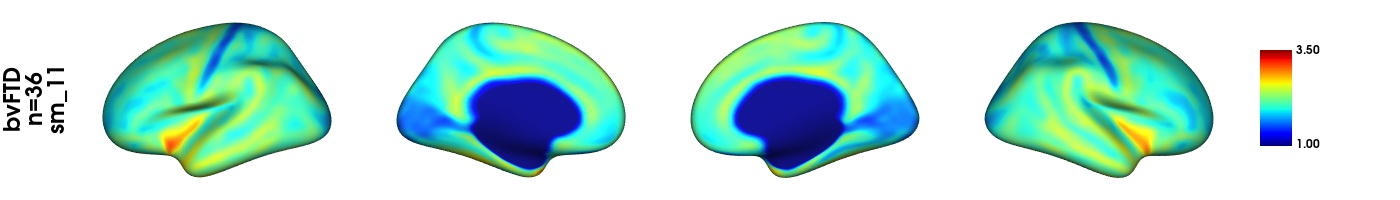

figure_title : /NAS/dumbo/protocoles/PSY_bvFTD/screenshots/CTSurface_groupscomparison_GROUPE_vs_PPD_sm11.jpg


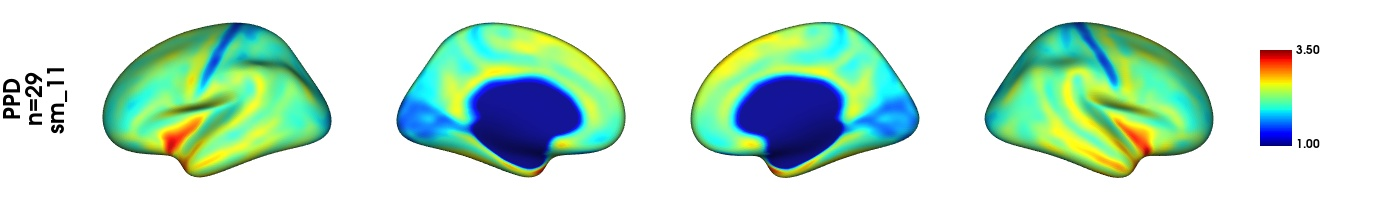

figure_title : /NAS/dumbo/protocoles/PSY_bvFTD/screenshots/CTSurface_groupscomparison_SOUS_GROUPE_vs_bvFTD_sm11.jpg


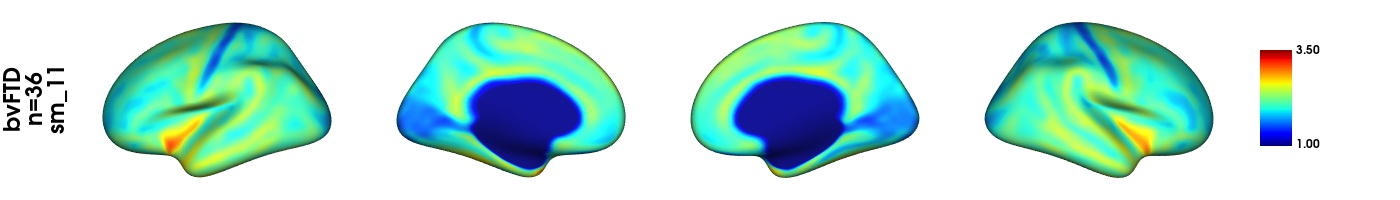

figure_title : /NAS/dumbo/protocoles/PSY_bvFTD/screenshots/CTSurface_groupscomparison_SOUS_GROUPE_vs_BPD_sm11.jpg


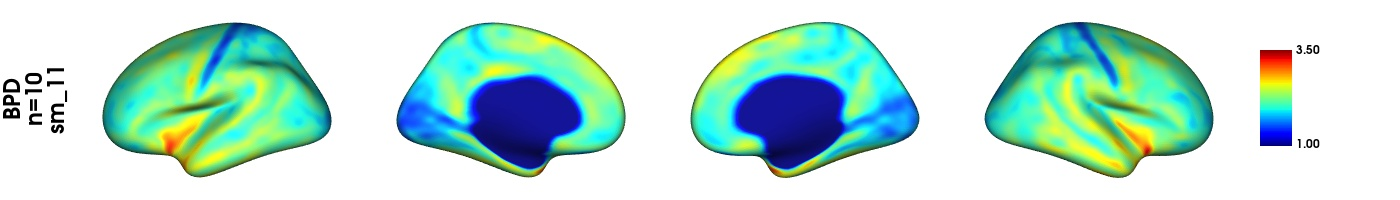

figure_title : /NAS/dumbo/protocoles/PSY_bvFTD/screenshots/CTSurface_groupscomparison_SOUS_GROUPE_vs_ADS_sm11.jpg


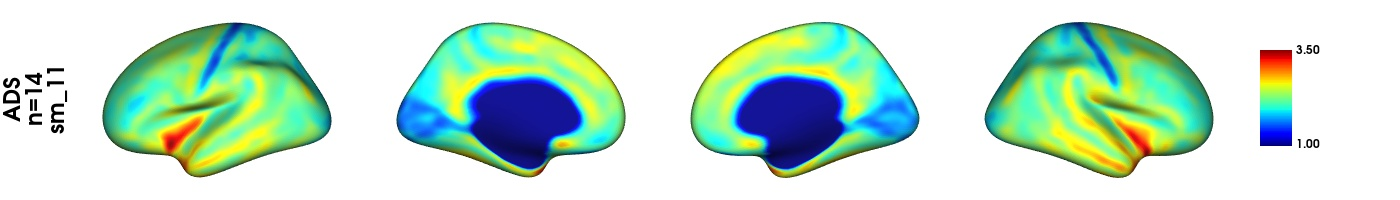

figure_title : /NAS/dumbo/protocoles/PSY_bvFTD/screenshots/CTSurface_groupscomparison_GROUPE_vs_bvFTD_sm15.jpg


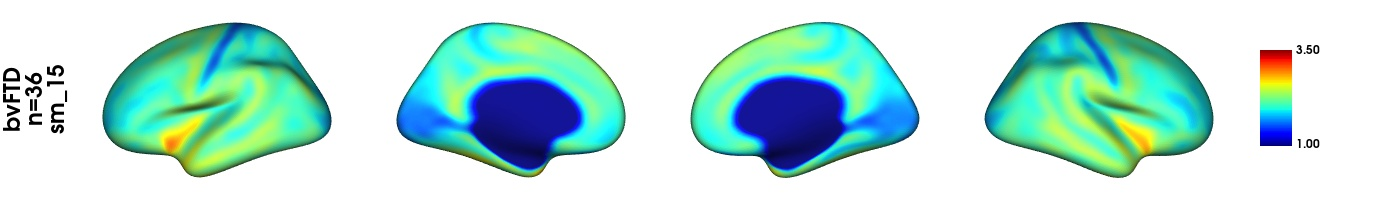

figure_title : /NAS/dumbo/protocoles/PSY_bvFTD/screenshots/CTSurface_groupscomparison_GROUPE_vs_PPD_sm15.jpg


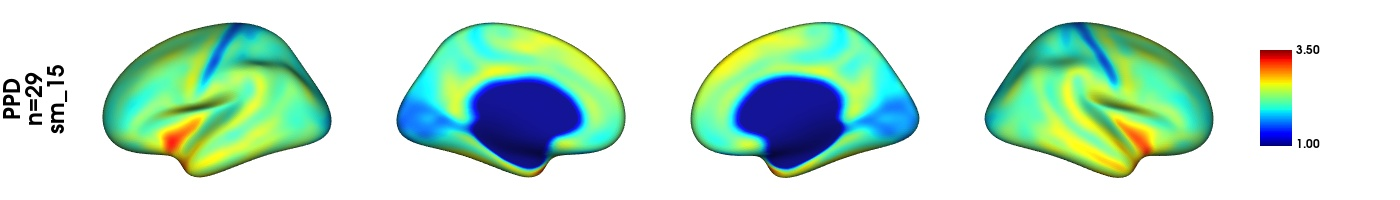

figure_title : /NAS/dumbo/protocoles/PSY_bvFTD/screenshots/CTSurface_groupscomparison_SOUS_GROUPE_vs_bvFTD_sm15.jpg


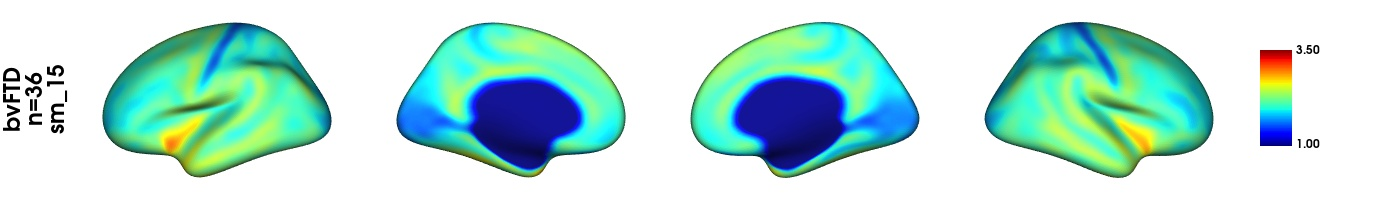

figure_title : /NAS/dumbo/protocoles/PSY_bvFTD/screenshots/CTSurface_groupscomparison_SOUS_GROUPE_vs_BPD_sm15.jpg


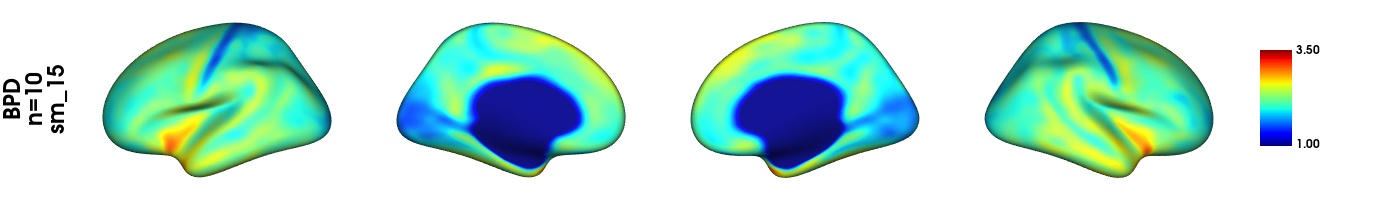

figure_title : /NAS/dumbo/protocoles/PSY_bvFTD/screenshots/CTSurface_groupscomparison_SOUS_GROUPE_vs_ADS_sm15.jpg


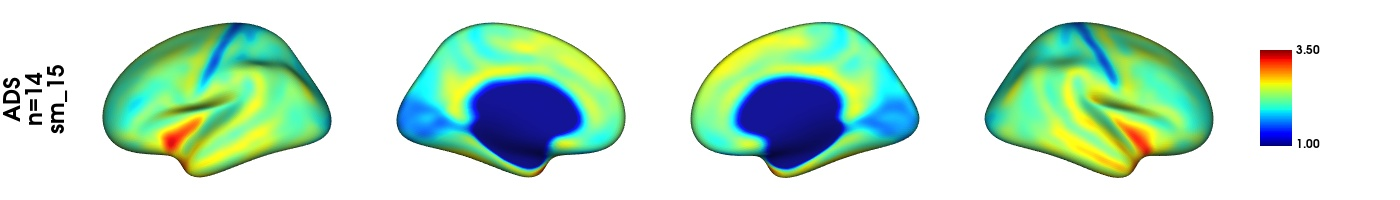

figure_title : /NAS/dumbo/protocoles/PSY_bvFTD/screenshots/CTSurface_groupscomparison_GROUPE_vs_bvFTD_sm20.jpg


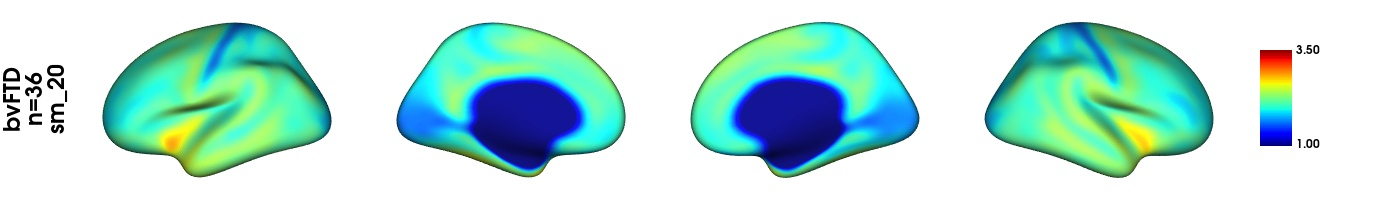

figure_title : /NAS/dumbo/protocoles/PSY_bvFTD/screenshots/CTSurface_groupscomparison_GROUPE_vs_PPD_sm20.jpg


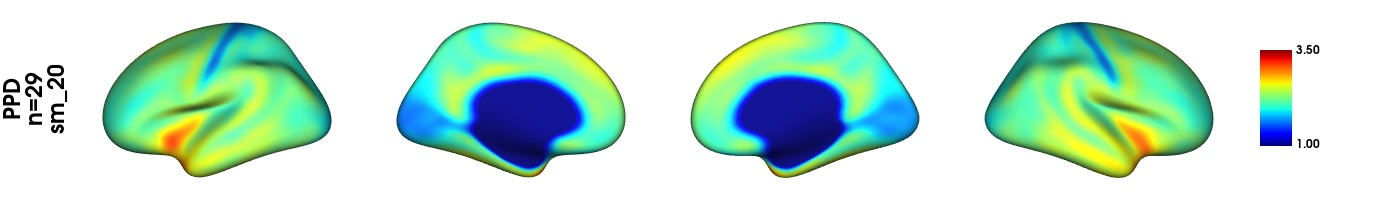

figure_title : /NAS/dumbo/protocoles/PSY_bvFTD/screenshots/CTSurface_groupscomparison_SOUS_GROUPE_vs_bvFTD_sm20.jpg


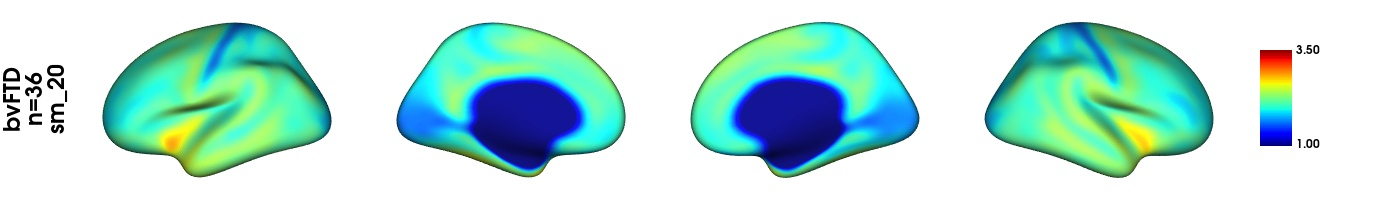

figure_title : /NAS/dumbo/protocoles/PSY_bvFTD/screenshots/CTSurface_groupscomparison_SOUS_GROUPE_vs_BPD_sm20.jpg


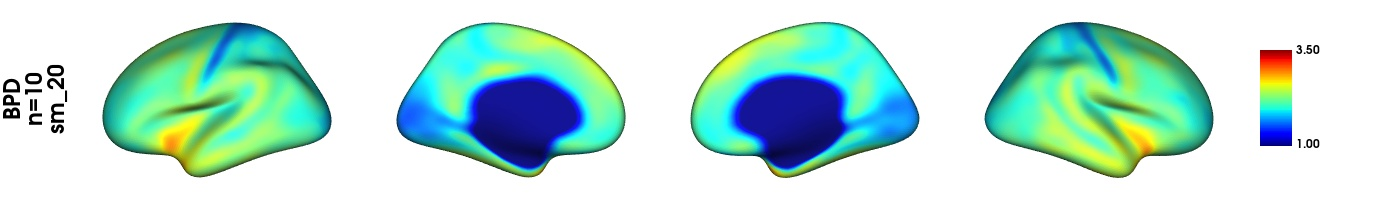

figure_title : /NAS/dumbo/protocoles/PSY_bvFTD/screenshots/CTSurface_groupscomparison_SOUS_GROUPE_vs_ADS_sm20.jpg


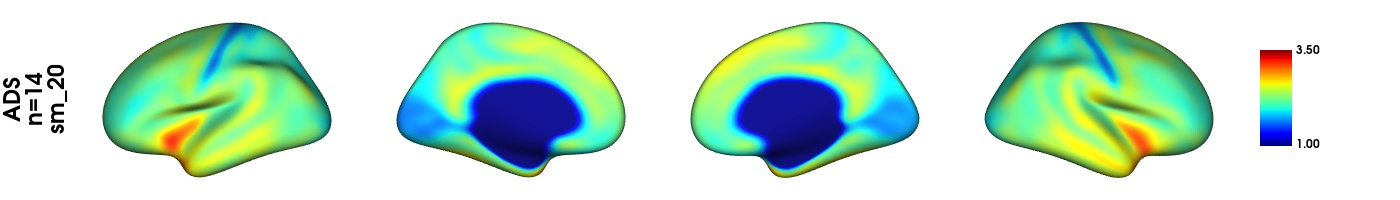

figure_title : /NAS/dumbo/protocoles/PSY_bvFTD/screenshots/CTSurface_groupscomparison_GROUPE_vs_bvFTD_sm25.jpg


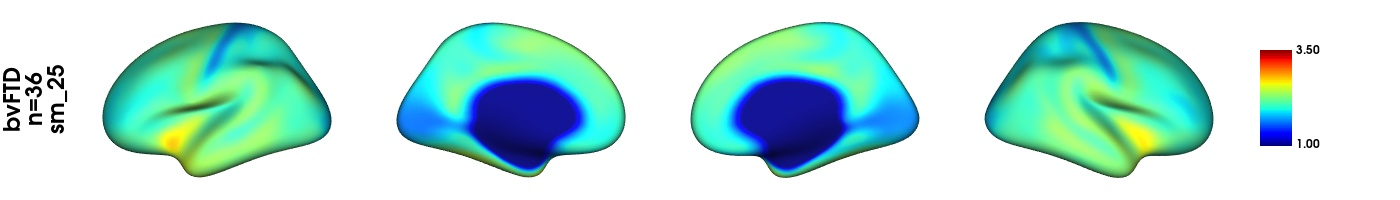

figure_title : /NAS/dumbo/protocoles/PSY_bvFTD/screenshots/CTSurface_groupscomparison_GROUPE_vs_PPD_sm25.jpg


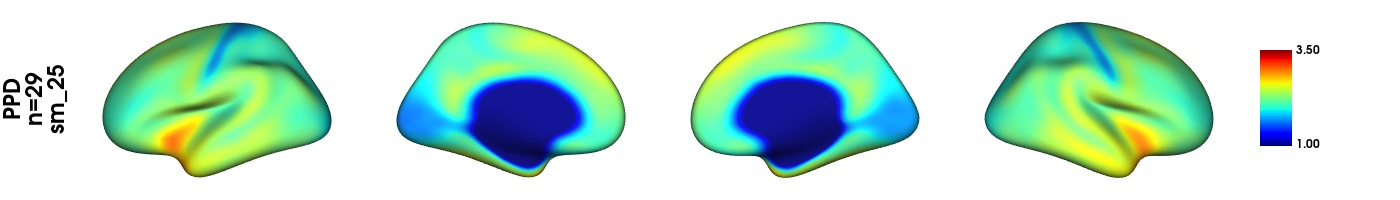

figure_title : /NAS/dumbo/protocoles/PSY_bvFTD/screenshots/CTSurface_groupscomparison_SOUS_GROUPE_vs_bvFTD_sm25.jpg


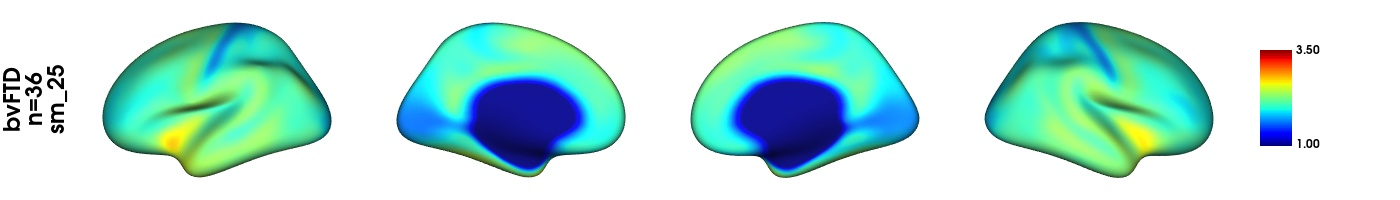

figure_title : /NAS/dumbo/protocoles/PSY_bvFTD/screenshots/CTSurface_groupscomparison_SOUS_GROUPE_vs_BPD_sm25.jpg


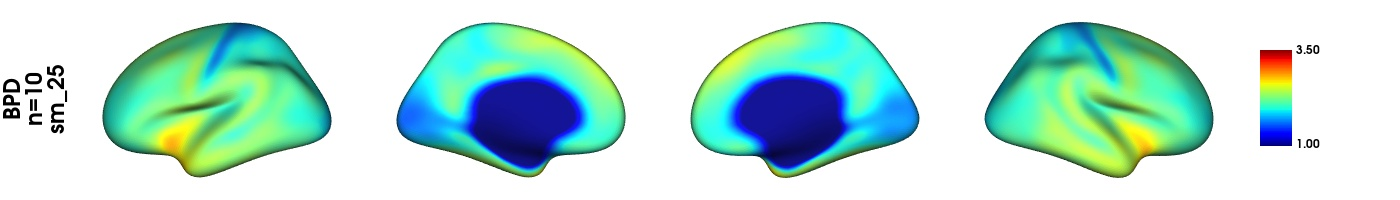

figure_title : /NAS/dumbo/protocoles/PSY_bvFTD/screenshots/CTSurface_groupscomparison_SOUS_GROUPE_vs_ADS_sm25.jpg


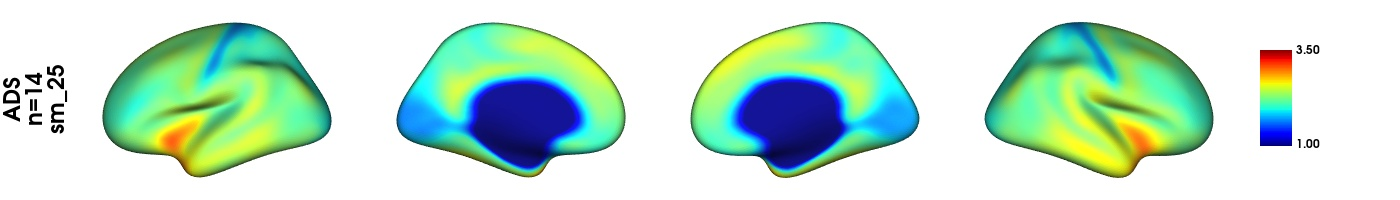

figure_title : /NAS/dumbo/protocoles/PSY_bvFTD/screenshots/CTSurface_groupscomparison_GROUPE_vs_bvFTD_sm30.jpg


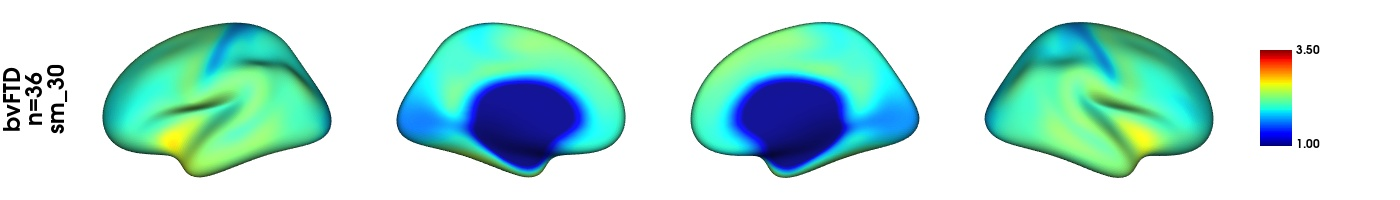

figure_title : /NAS/dumbo/protocoles/PSY_bvFTD/screenshots/CTSurface_groupscomparison_GROUPE_vs_PPD_sm30.jpg


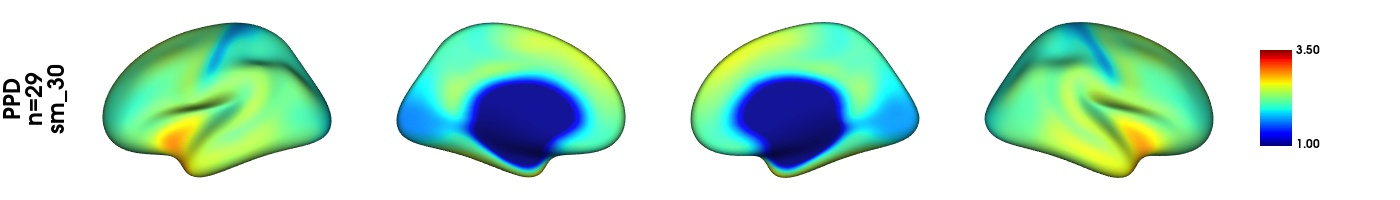

figure_title : /NAS/dumbo/protocoles/PSY_bvFTD/screenshots/CTSurface_groupscomparison_SOUS_GROUPE_vs_bvFTD_sm30.jpg


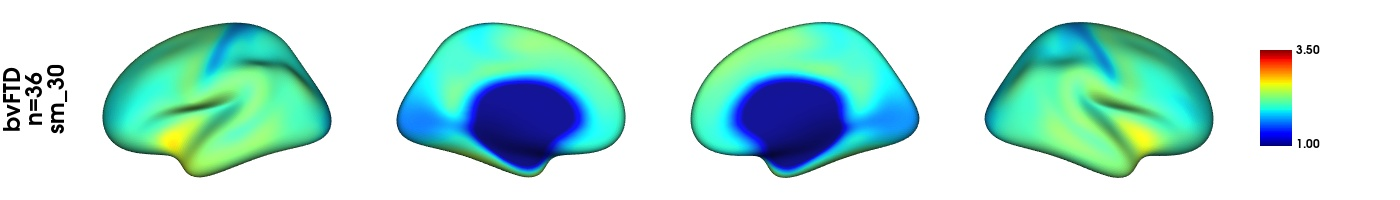

figure_title : /NAS/dumbo/protocoles/PSY_bvFTD/screenshots/CTSurface_groupscomparison_SOUS_GROUPE_vs_BPD_sm30.jpg


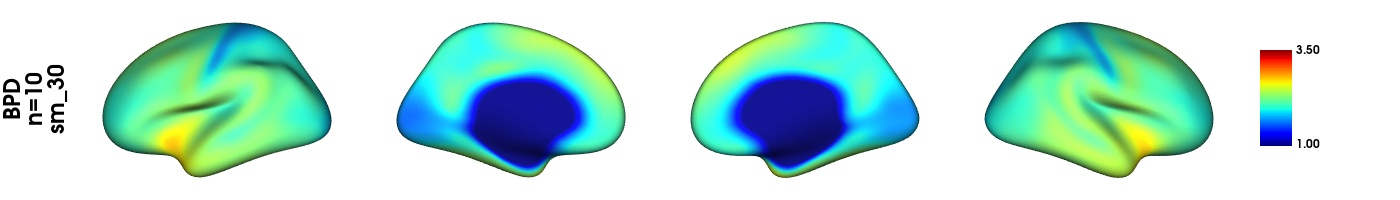

figure_title : /NAS/dumbo/protocoles/PSY_bvFTD/screenshots/CTSurface_groupscomparison_SOUS_GROUPE_vs_ADS_sm30.jpg


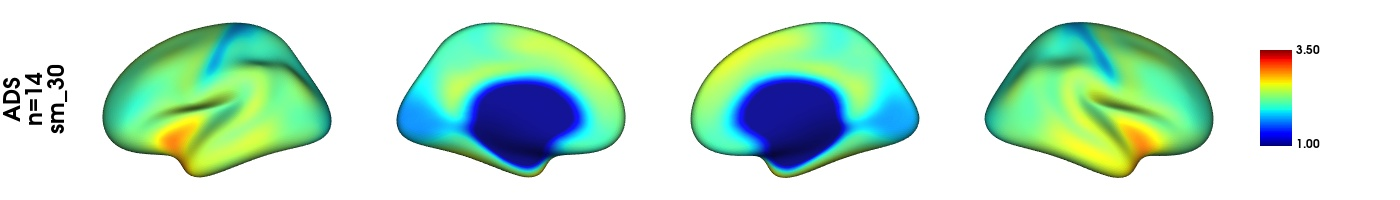

In [19]:
for smoothing_fwhm in chain([11], range(15, 31, 5)):
        #Plot the average thickness of the left and right hemispheres on the fsaverage5 surface    
        for groupUsed in ['GROUPE','SOUS_GROUPE'] :
                for gp in merged_data[groupUsed].dropna().unique():
                        figure_title=os.path.join(STUDY_PATH,"screenshots",f"CTSurface_groupscomparison_{groupUsed}_vs_{gp}_sm{smoothing_fwhm}.jpg")
                        df_etude1_CT = pd.DataFrame(np.array(valCT[f"sm_{smoothing_fwhm}"]), index=merged_data.index)       
                #        labText=f"{np.sum(ssdf_covar[groupUsed] == pair[0])} {pair[0]}\n{np.sum(ssdf_covar[groupUsed] == pair[1])} {pair[1]}"
                        df_tmp_gp=df_etude1_CT.loc[merged_data[groupUsed] == gp]
                        plot_hemispheres(inflated_left, inflated_right,np.mean(df_tmp_gp,axis=0).values, color_bar=True, color_range=(1, 3.5),
                                label_text=[f"{gp}\nn={len(df_tmp_gp)}\nsm_{smoothing_fwhm}"], cmap="jet", embed_nb=True, size=(1400, 200), zoom=1.45,
                                nan_color=(0.7, 0.7, 0.7, 1), transparent_bg=False,cb__labelTextProperty={"fontSize": 12}, interactive=True,screenshot=True, offscreen=False,filename=figure_title)
                        #cmap="autumn",label_text=[labText],
                        print(f"figure_title : {figure_title}")                        
                        display(Image(filename=figure_title))

La bibil à RORO loaded
******************************
GROUPE, smooting à 11
***************************** 
Group comparison between bvFTD and PPD
fitting the model
/NAS/dumbo/protocoles/PSY_bvFTD/screenshots/sm_11/CTSurface_groupscomparison_bvFTD_vs_PPD_contrast1.jpg


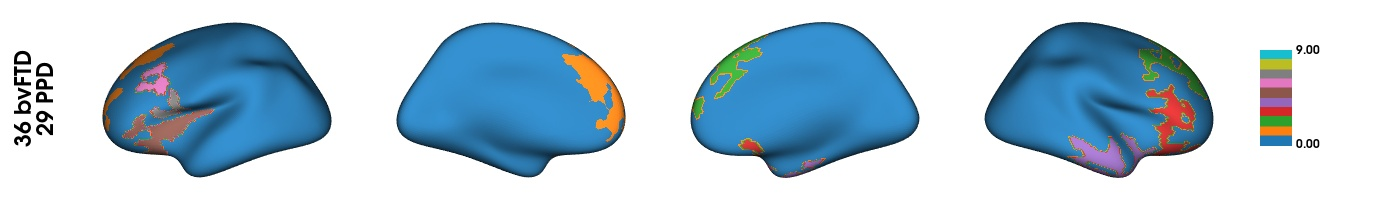

***** 
 clusters infos : 
***** 
     clusid  nverts     resels         P
0       1   510.0  16.713885  0.000003
1       2   512.0  15.827609  0.000003
2       3   365.0  11.548274  0.000003
3       4   450.0  10.459702  0.000003
4       5   317.0   8.745107  0.000004
5       6    85.0   3.568550  0.003727
6       7   104.0   3.189162  0.007695
***** 
 peaks infos : 
***** 
              t  clusid  vertid          P
0    4.639951       5    5013   0.054164
1    4.590687       5    9108   0.063228
2    4.528091       3   16434   0.076888
3    4.506652       4   20481   0.082213
4    4.380724       1    7585   0.121159
..        ...     ...     ...        ...
145  2.692733       2   12054   9.457823
150  2.658819       1     499  10.117769
152  2.648728       2   14941  10.323353
165  2.576747       1    2141  11.869220
167  2.574372       4   11998  11.923023

[95 rows x 4 columns]
  cluster_1 
/NAS/dumbo/protocoles/PSY_bvFTD/screenshots/sm_11/groups_compare_cluster_1_contrast1.png


/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


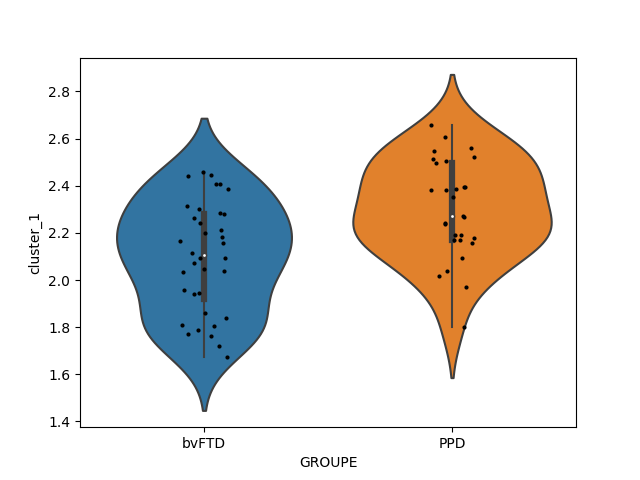

T-Test (oneside) : -3.691 and p_value = 0.000
  cluster_2 
/NAS/dumbo/protocoles/PSY_bvFTD/screenshots/sm_11/groups_compare_cluster_2_contrast1.png


/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


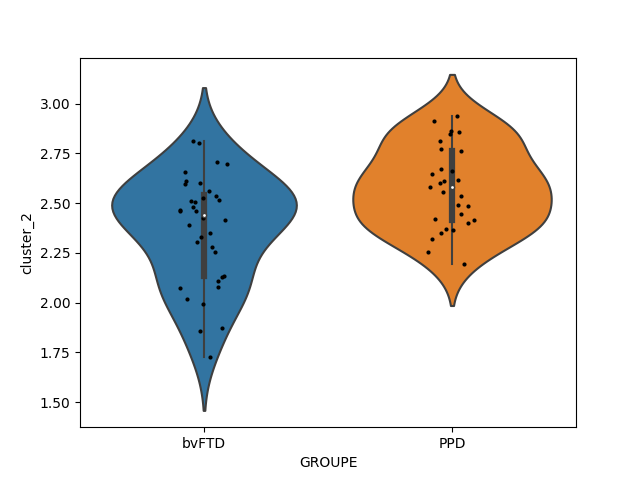

T-Test (oneside) : -3.531 and p_value = 0.001
  cluster_3 


/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


/NAS/dumbo/protocoles/PSY_bvFTD/screenshots/sm_11/groups_compare_cluster_3_contrast1.png


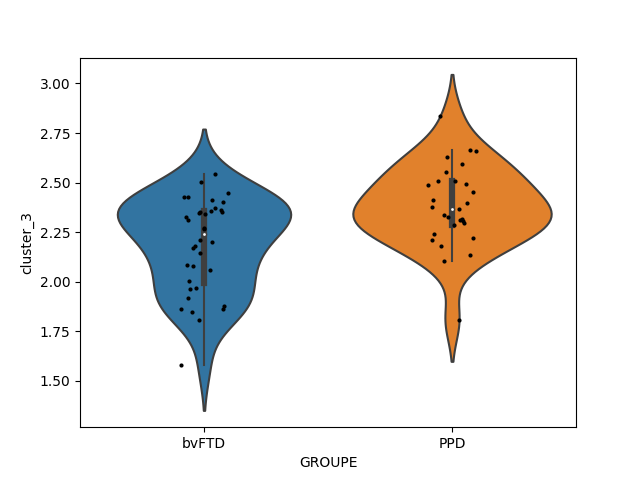

T-Test (oneside) : -3.578 and p_value = 0.001
  cluster_4 
/NAS/dumbo/protocoles/PSY_bvFTD/screenshots/sm_11/groups_compare_cluster_4_contrast1.png


/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


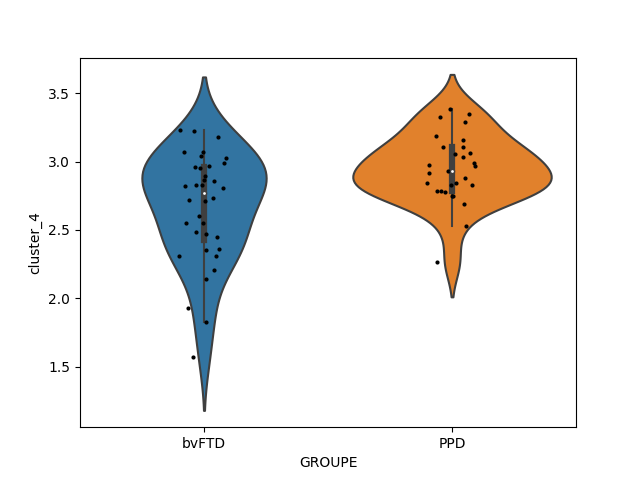

T-Test (oneside) : -3.451 and p_value = 0.001
  cluster_5 


/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


/NAS/dumbo/protocoles/PSY_bvFTD/screenshots/sm_11/groups_compare_cluster_5_contrast1.png


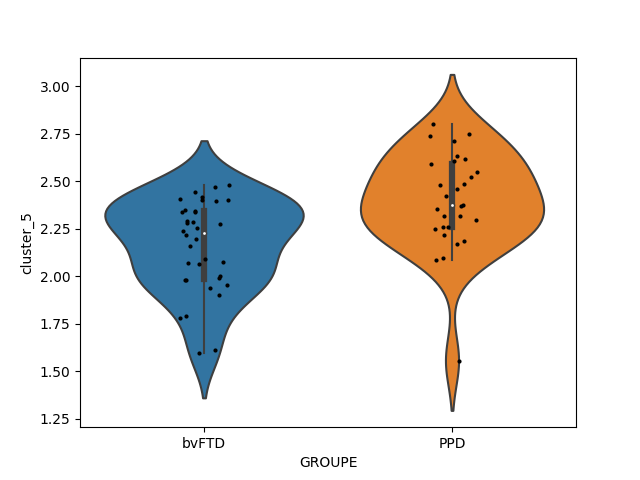

T-Test (oneside) : -3.768 and p_value = 0.000
  cluster_6 


/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


/NAS/dumbo/protocoles/PSY_bvFTD/screenshots/sm_11/groups_compare_cluster_6_contrast1.png


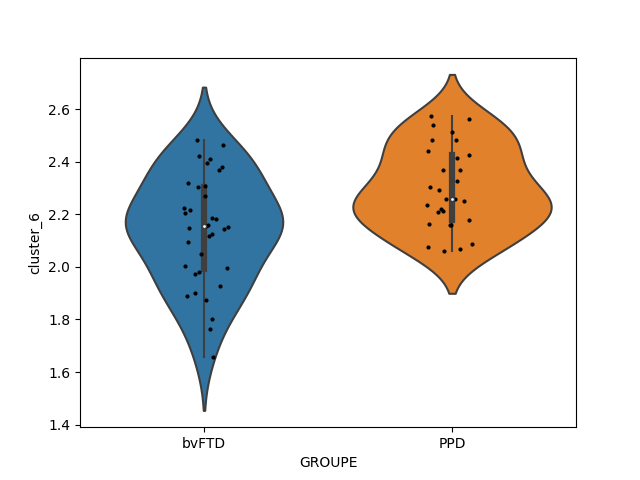

T-Test (oneside) : -3.542 and p_value = 0.001
  cluster_7 


/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


/NAS/dumbo/protocoles/PSY_bvFTD/screenshots/sm_11/groups_compare_cluster_7_contrast1.png


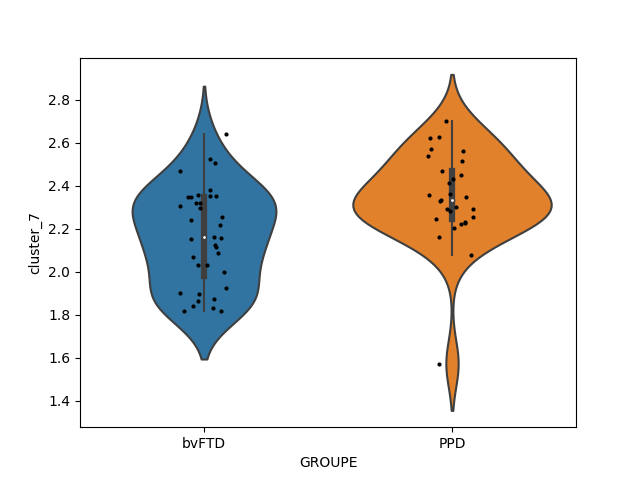

T-Test (oneside) : -3.285 and p_value = 0.002
******************************
SOUS_GROUPE, smooting à 11
***************************** 
Group comparison between bvFTD and BPD
fitting the model
Group comparison between bvFTD and ADS
fitting the model
/NAS/dumbo/protocoles/PSY_bvFTD/screenshots/sm_11/CTSurface_groupscomparison_bvFTD_vs_ADS_contrast1.jpg


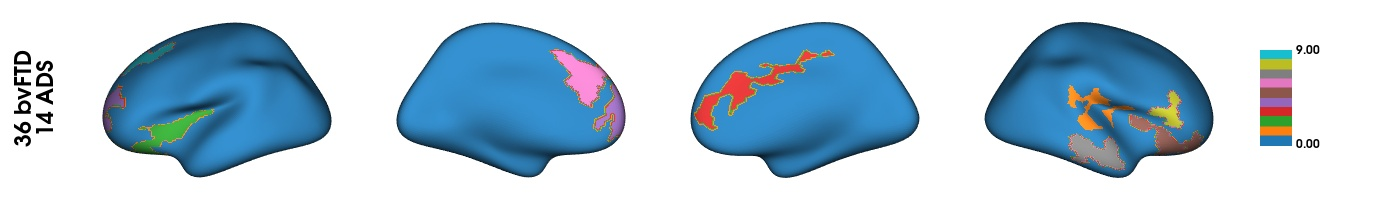

***** 
 clusters infos : 
***** 
     clusid  nverts     resels         P
0       1   325.0  10.341555  0.000004
1       2   301.0   8.952919  0.000006
2       3   227.0   8.077651  0.000012
3       4   240.0   7.929254  0.000014
4       5   199.0   6.098244  0.000112
5       6   154.0   5.848338  0.000156
6       7   162.0   3.877714  0.003066
7       8   104.0   3.647672  0.004521
8       9    97.0   3.448326  0.006379
***** 
 peaks infos : 
***** 
              t  clusid  vertid          P
0    5.092702       1   14521   0.022639
2    4.893175       2    2259   0.040916
3    4.839088       1   10666   0.047912
4    4.805857       1   16848   0.052872
5    4.725246       2    5015   0.066901
..        ...     ...     ...        ...
178  2.649462       3   13676  11.393929
186  2.615147       3   14401  12.148185
199  2.562266       2    9254  13.382386
201  2.544824       5   16839  13.813786
204  2.538147       3   19011  13.979854

[69 rows x 4 columns]
  cluster_1 
/NAS/dumbo/prot

/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


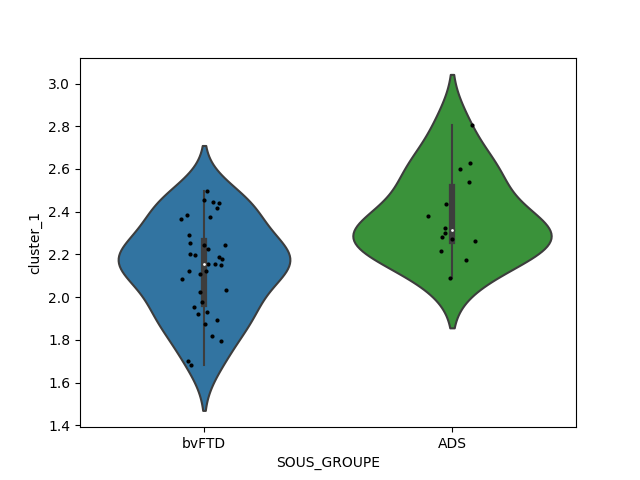

T-Test (oneside) : -3.764 and p_value = 0.001
  cluster_2 


/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


/NAS/dumbo/protocoles/PSY_bvFTD/screenshots/sm_11/groups_compare_cluster_2_contrast1.png


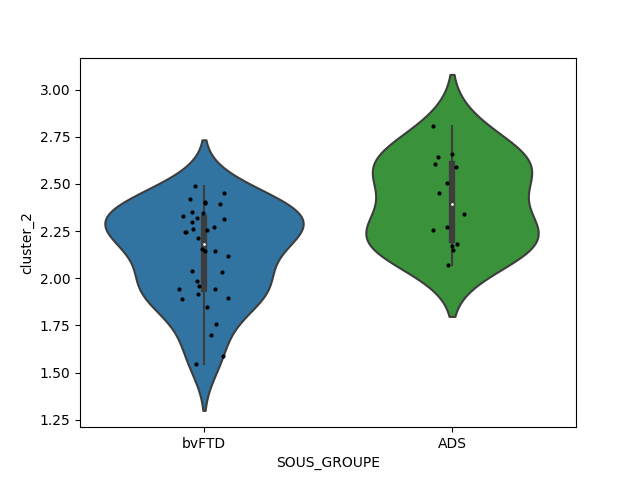

T-Test (oneside) : -3.767 and p_value = 0.001
  cluster_3 


/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


/NAS/dumbo/protocoles/PSY_bvFTD/screenshots/sm_11/groups_compare_cluster_3_contrast1.png


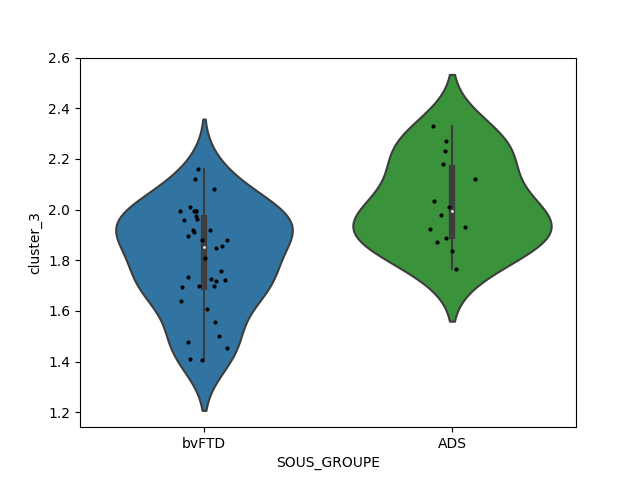

T-Test (oneside) : -3.848 and p_value = 0.001
  cluster_4 


/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


/NAS/dumbo/protocoles/PSY_bvFTD/screenshots/sm_11/groups_compare_cluster_4_contrast1.png


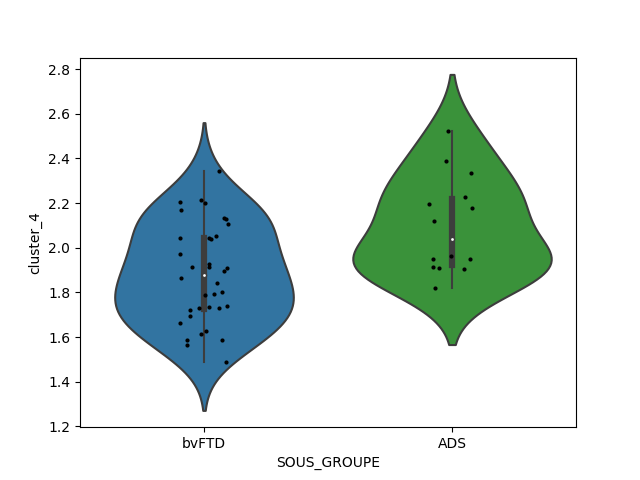

T-Test (oneside) : -3.162 and p_value = 0.004
  cluster_5 


/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


/NAS/dumbo/protocoles/PSY_bvFTD/screenshots/sm_11/groups_compare_cluster_5_contrast1.png


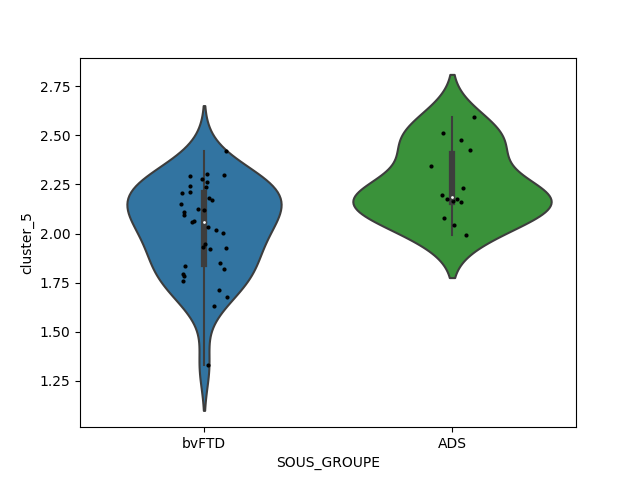

T-Test (oneside) : -3.694 and p_value = 0.001
  cluster_6 
/NAS/dumbo/protocoles/PSY_bvFTD/screenshots/sm_11/groups_compare_cluster_6_contrast1.png


/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


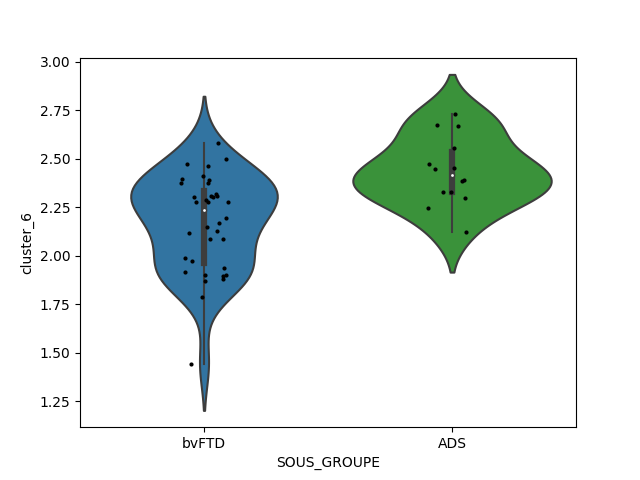

T-Test (oneside) : -4.300 and p_value = 0.000
  cluster_7 


/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


/NAS/dumbo/protocoles/PSY_bvFTD/screenshots/sm_11/groups_compare_cluster_7_contrast1.png


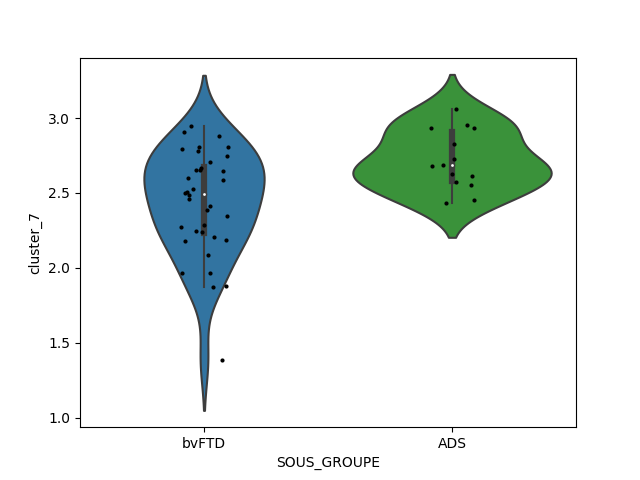

T-Test (oneside) : -3.657 and p_value = 0.001
  cluster_8 


/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


/NAS/dumbo/protocoles/PSY_bvFTD/screenshots/sm_11/groups_compare_cluster_8_contrast1.png


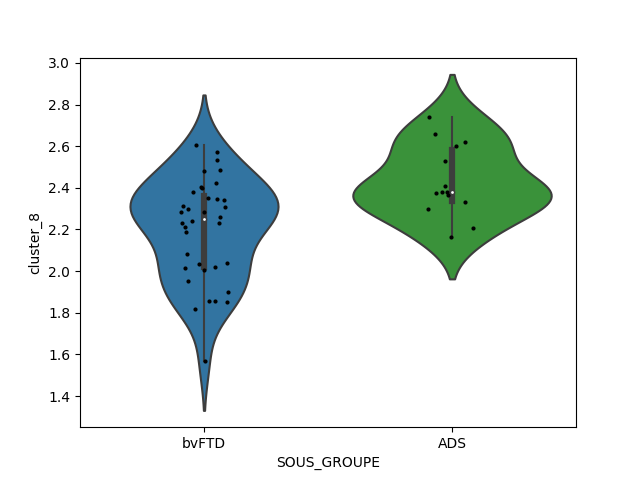

T-Test (oneside) : -3.801 and p_value = 0.001
  cluster_9 


/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


/NAS/dumbo/protocoles/PSY_bvFTD/screenshots/sm_11/groups_compare_cluster_9_contrast1.png


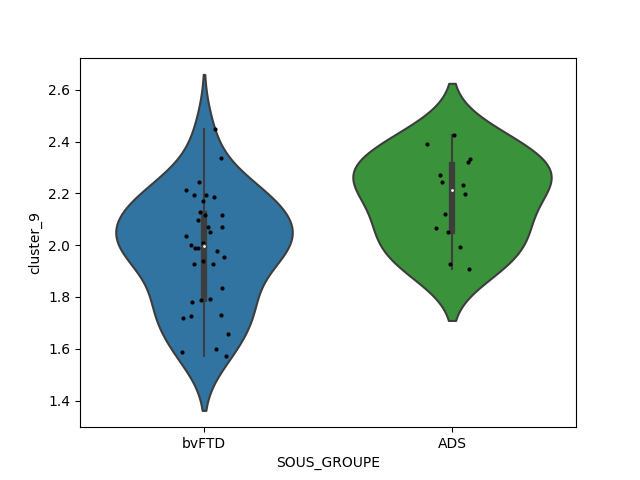

T-Test (oneside) : -3.485 and p_value = 0.002
Group comparison between BPD and ADS
fitting the model
******************************
GROUPE, smooting à 15
***************************** 
Group comparison between bvFTD and PPD
fitting the model
/NAS/dumbo/protocoles/PSY_bvFTD/screenshots/sm_15/CTSurface_groupscomparison_bvFTD_vs_PPD_contrast1.jpg


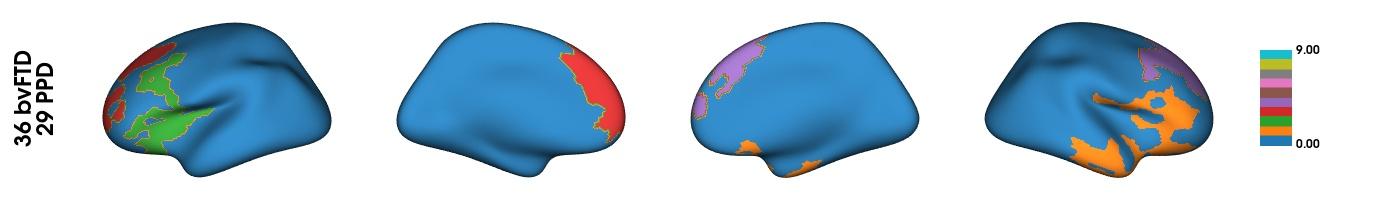

***** 
 clusters infos : 
***** 
     clusid  nverts     resels         P
0       1  1216.0  16.210667  0.000001
1       2   689.0  10.642654  0.000001
2       3   650.0   9.419302  0.000002
3       4   654.0   9.033626  0.000002
***** 
 peaks infos : 
***** 
              t  clusid  vertid         P
0    4.644903       2    1191  0.026993
1    4.360734       3    7585  0.065182
2    4.218452       1   20481  0.100132
3    4.214237       2    9108  0.101373
4    4.154355       1   16434  0.121015
..        ...     ...     ...       ...
88   2.740998       1   17846  4.366735
90   2.721235       2    2825  4.544685
99   2.604865       1   17508  5.727390
100  2.601222       3    4724  5.767582
111  2.492183       1   16996  7.084022

[69 rows x 4 columns]
  cluster_1 
/NAS/dumbo/protocoles/PSY_bvFTD/screenshots/sm_15/groups_compare_cluster_1_contrast1.png


/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


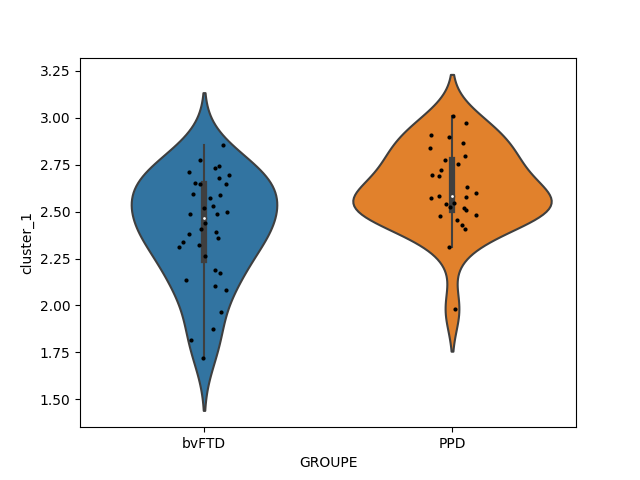

T-Test (oneside) : -3.446 and p_value = 0.001
  cluster_2 
/NAS/dumbo/protocoles/PSY_bvFTD/screenshots/sm_15/groups_compare_cluster_2_contrast1.png


/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


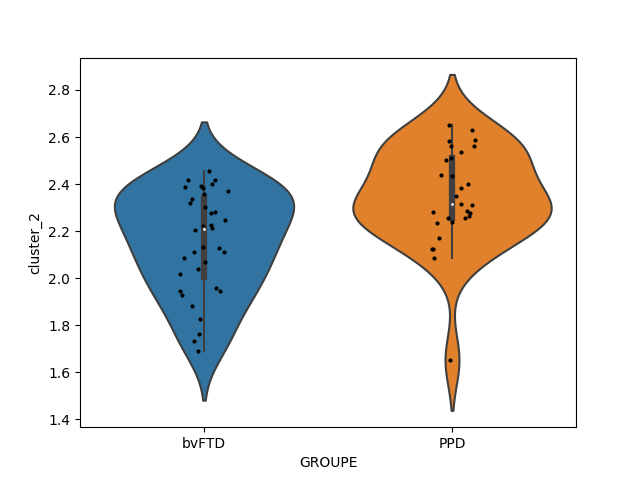

T-Test (oneside) : -3.584 and p_value = 0.001
  cluster_3 


/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


/NAS/dumbo/protocoles/PSY_bvFTD/screenshots/sm_15/groups_compare_cluster_3_contrast1.png


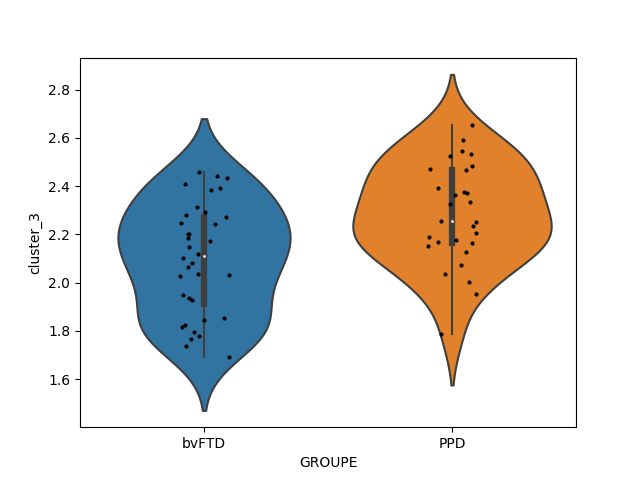

T-Test (oneside) : -3.460 and p_value = 0.001
  cluster_4 


/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


/NAS/dumbo/protocoles/PSY_bvFTD/screenshots/sm_15/groups_compare_cluster_4_contrast1.png


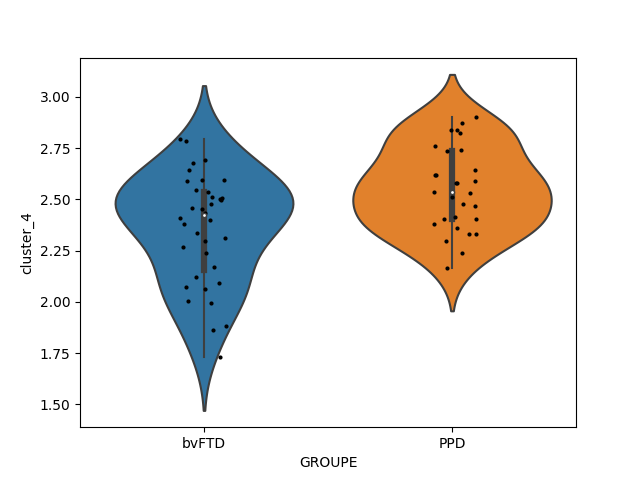

T-Test (oneside) : -3.298 and p_value = 0.002
******************************
SOUS_GROUPE, smooting à 15
***************************** 
Group comparison between bvFTD and BPD
fitting the model
Group comparison between bvFTD and ADS
fitting the model
/NAS/dumbo/protocoles/PSY_bvFTD/screenshots/sm_15/CTSurface_groupscomparison_bvFTD_vs_ADS_contrast1.jpg


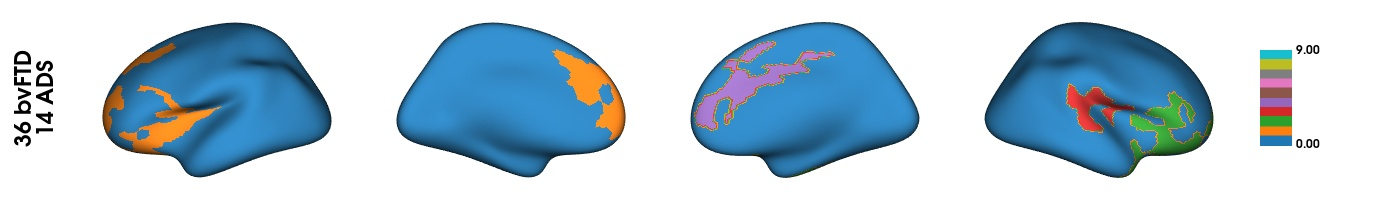

***** 
 clusters infos : 
***** 
     clusid  nverts     resels         P
0       1  1180.0  18.525326  0.000002
1       2   630.0   8.807053  0.000004
2       3   401.0   6.735176  0.000025
3       4   322.0   5.902045  0.000073
***** 
 peaks infos : 
***** 
              t  clusid  vertid         P
0    5.205865       3   18687  0.008185
1    4.660658       1    1191  0.040988
3    4.605966       1    5015  0.048024
4    4.602890       1    2259  0.048453
6    4.524961       1     254  0.060522
7    4.507517       3   10749  0.063602
8    4.276619       1    3848  0.121470
9    4.215655       2   12406  0.143718
10   4.090232       1    7586  0.202083
11   4.085704       1    1116  0.204483
12   4.058545       1    2660  0.220135
13   4.019510       1    9108  0.244361
14   3.956746       4   19475  0.288392
15   3.945668       1    1470  0.297182
16   3.923502       2   16181  0.314772
17   3.897640       2   12441  0.337144
18   3.862825       4   19430  0.369198
19   3.833757     

/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


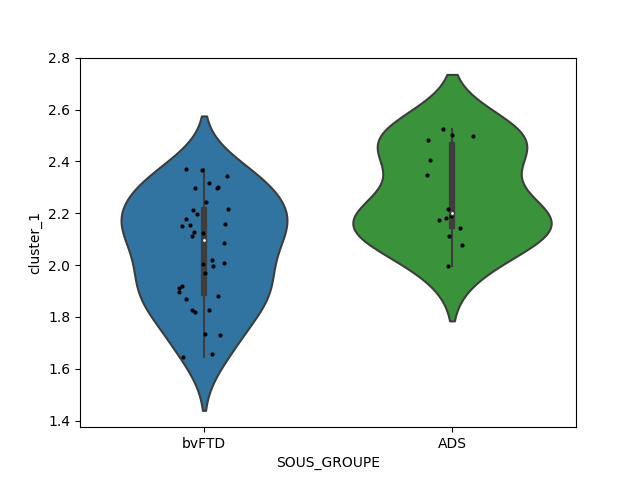

T-Test (oneside) : -3.719 and p_value = 0.001
  cluster_2 


/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


/NAS/dumbo/protocoles/PSY_bvFTD/screenshots/sm_15/groups_compare_cluster_2_contrast1.png


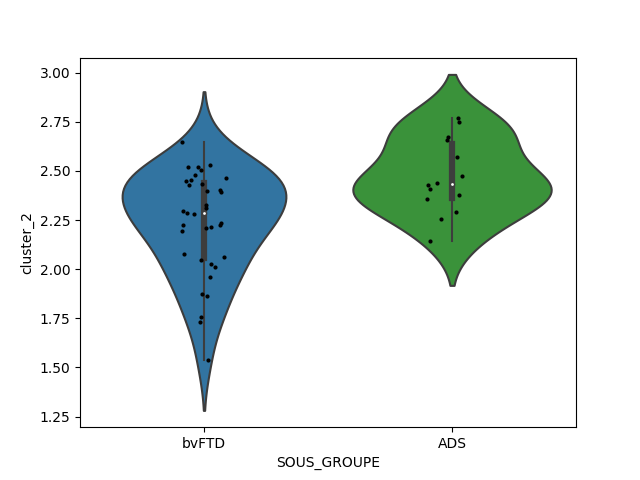

T-Test (oneside) : -3.556 and p_value = 0.001
  cluster_3 


/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


/NAS/dumbo/protocoles/PSY_bvFTD/screenshots/sm_15/groups_compare_cluster_3_contrast1.png


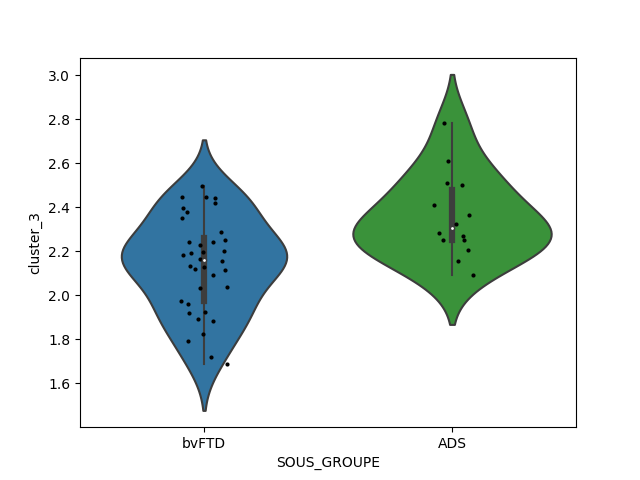

T-Test (oneside) : -3.555 and p_value = 0.001
  cluster_4 


/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


/NAS/dumbo/protocoles/PSY_bvFTD/screenshots/sm_15/groups_compare_cluster_4_contrast1.png


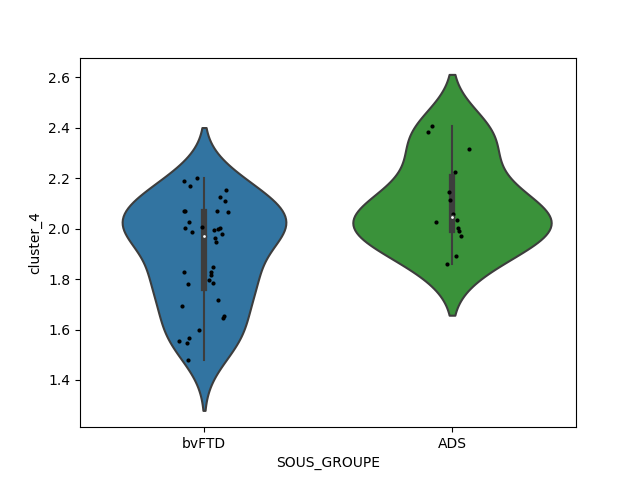

T-Test (oneside) : -3.564 and p_value = 0.001
Group comparison between BPD and ADS
fitting the model
******************************
GROUPE, smooting à 20
***************************** 
Group comparison between bvFTD and PPD
fitting the model
/NAS/dumbo/protocoles/PSY_bvFTD/screenshots/sm_20/CTSurface_groupscomparison_bvFTD_vs_PPD_contrast1.jpg


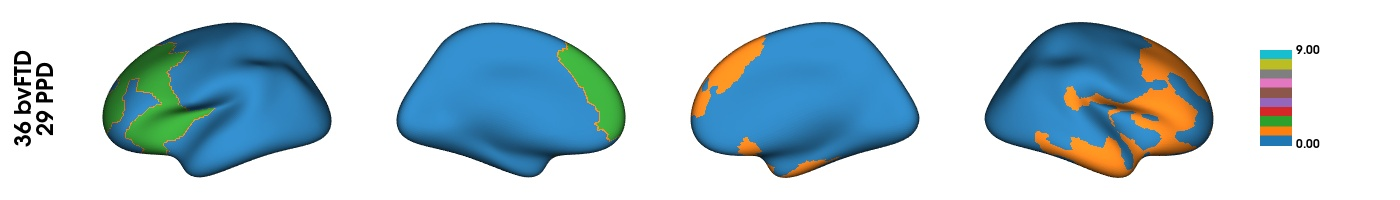

***** 
 clusters infos : 
***** 
     clusid  nverts     resels             P
0       1  2495.0  15.379201  6.080881e-07
1       2  1642.0  10.827617  6.316824e-07
***** 
 peaks infos : 
***** 
             t  clusid  vertid         P
0   4.415553       2    6752  0.026532
1   4.251594       2    7586  0.043663
2   3.937979       1   16433  0.109276
3   3.893350       2    9108  0.123976
4   3.825546       1   12804  0.149943
5   3.816818       2    4077  0.153617
6   3.807485       2    6561  0.157545
7   3.800157       2    7887  0.160734
8   3.792685       1   19215  0.164210
9   3.782530       1   17430  0.168936
10  3.738175       1   18905  0.190804
11  3.719465       1   16179  0.200699
12  3.681985       2     243  0.222168
13  3.679946       1   12277  0.223438
14  3.645062       1   15693  0.245356
15  3.590761       2    7427  0.283801
17  3.532949       1   17664  0.330127
18  3.501019       1   13773  0.358851
19  3.489929       1   16886  0.369404
20  3.455568       1   1

/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


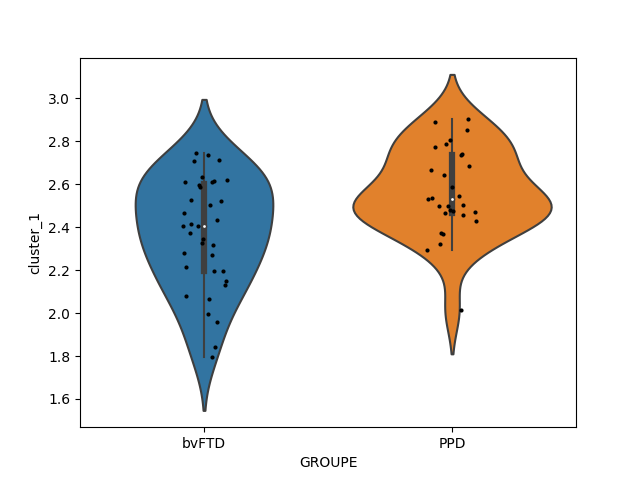

T-Test (oneside) : -3.368 and p_value = 0.001
  cluster_2 


/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


/NAS/dumbo/protocoles/PSY_bvFTD/screenshots/sm_20/groups_compare_cluster_2_contrast1.png


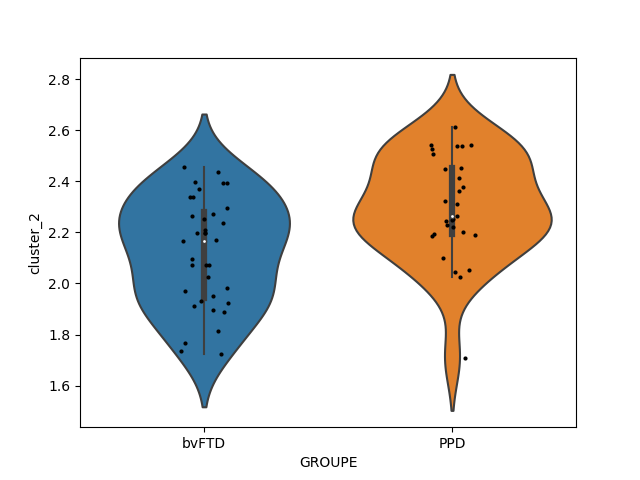

T-Test (oneside) : -3.408 and p_value = 0.001
******************************
SOUS_GROUPE, smooting à 20
***************************** 
Group comparison between bvFTD and BPD
fitting the model
Group comparison between bvFTD and ADS
fitting the model
/NAS/dumbo/protocoles/PSY_bvFTD/screenshots/sm_20/CTSurface_groupscomparison_bvFTD_vs_ADS_contrast1.jpg


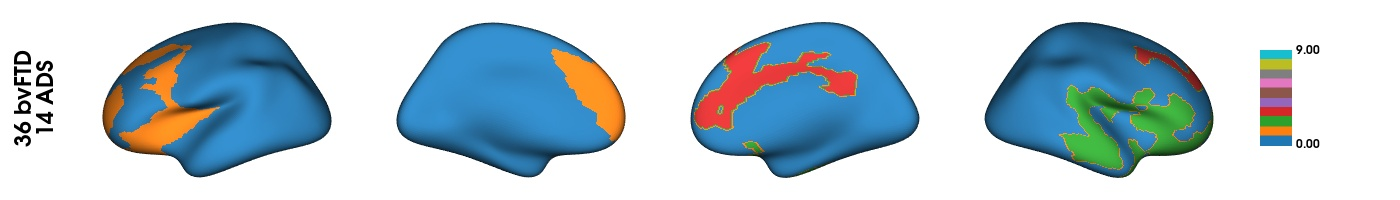

***** 
 clusters infos : 
***** 
     clusid  nverts     resels             P
0       1  1546.0  11.439673  8.318761e-07
1       2  1604.0  10.942907  8.691944e-07
2       3   744.0   6.031355  2.943853e-05
***** 
 peaks infos : 
***** 
             t  clusid  vertid         P
0   5.054507       2   18687  0.006229
1   4.562035       1    1191  0.026349
2   4.441483       1    7591  0.037104
5   4.039205       2   10749  0.112231
6   3.914028       2   12406  0.156542
7   3.848431       2   11374  0.185815
8   3.835434       1    9126  0.192185
9   3.755124       1    1470  0.236375
10  3.726424       1    2660  0.254166
11  3.679084       3   16476  0.286686
12  3.651509       3   10904  0.307166
13  3.640670       1    5909  0.315726
14  3.629250       2   10981  0.324991
16  3.561985       3   11397  0.383899
18  3.536108       1    4982  0.408845
19  3.528828       3   14416  0.416336
20  3.518420       1    4692  0.427251
21  3.515161       2   11043  0.430668
22  3.437890       1

/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


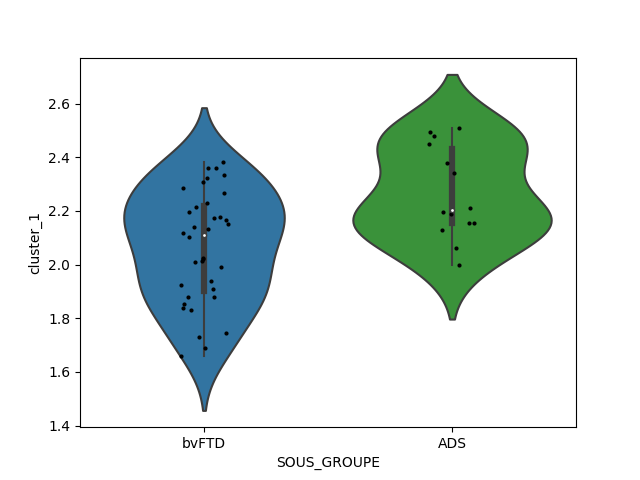

T-Test (oneside) : -3.528 and p_value = 0.001
  cluster_2 
/NAS/dumbo/protocoles/PSY_bvFTD/screenshots/sm_20/groups_compare_cluster_2_contrast1.png


/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


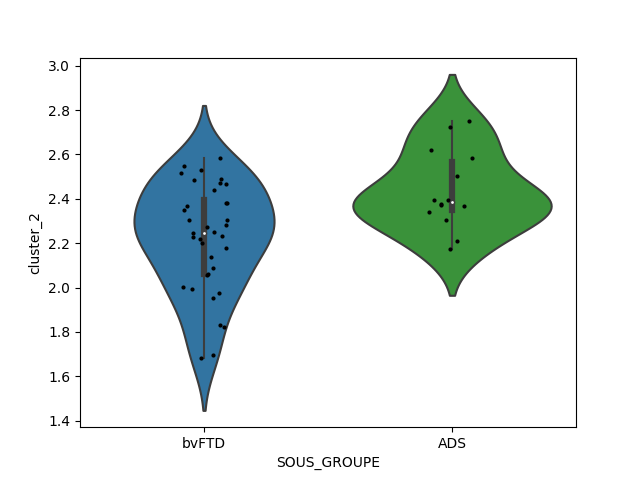

T-Test (oneside) : -3.465 and p_value = 0.002
  cluster_3 


/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


/NAS/dumbo/protocoles/PSY_bvFTD/screenshots/sm_20/groups_compare_cluster_3_contrast1.png


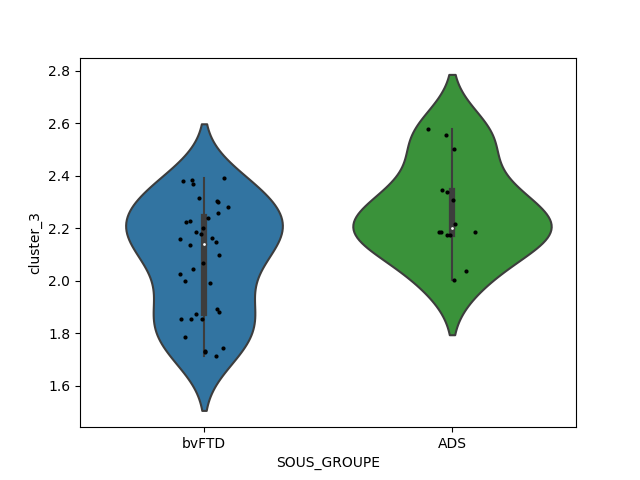

T-Test (oneside) : -3.177 and p_value = 0.004
Group comparison between BPD and ADS
fitting the model
******************************
GROUPE, smooting à 25
***************************** 
Group comparison between bvFTD and PPD
fitting the model
/NAS/dumbo/protocoles/PSY_bvFTD/screenshots/sm_25/CTSurface_groupscomparison_bvFTD_vs_PPD_contrast1.jpg


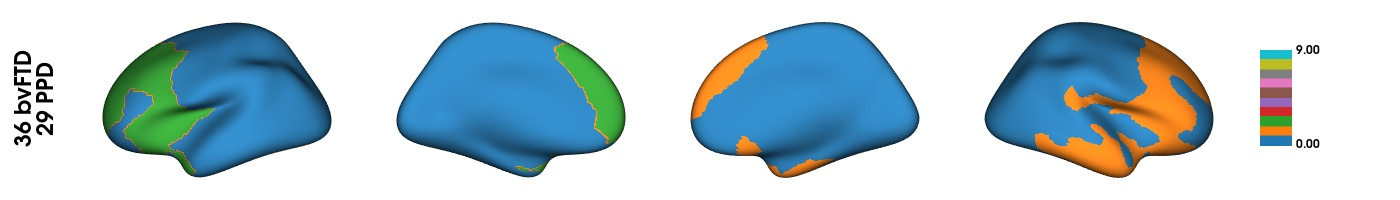

***** 
 clusters infos : 
***** 
     clusid  nverts    resels             P
0       1  2779.0  9.019575  4.440503e-07
1       2  1926.0  6.602227  3.470116e-06
***** 
 peaks infos : 
***** 
             t  clusid  vertid         P
0   4.183287       2    7586  0.029555
1   4.171088       2    6752  0.030630
2   3.816603       1   16432  0.084969
3   3.707858       2    1085  0.114652
4   3.634380       1   19213  0.139828
5   3.631253       2    8189  0.141015
6   3.626020       2    7887  0.143002
7   3.601370       1   18905  0.152681
8   3.593843       1   17430  0.155817
9   3.553842       1   20482  0.173213
10  3.530672       1   15693  0.183952
11  3.521545       1   17664  0.188511
12  3.514825       1   10840  0.191867
13  3.499507       1   14707  0.199519
14  3.468235       1   11978  0.216462
15  3.406432       1   16076  0.253668
16  3.386124       1   14093  0.266830
17  3.371886       1   16886  0.276835
18  3.286897       2    4444  0.342118
19  3.285610       2    411

/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


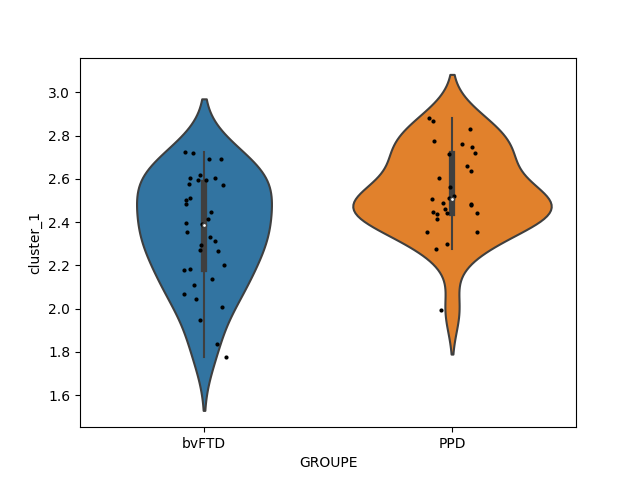

T-Test (oneside) : -3.264 and p_value = 0.002
  cluster_2 


/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


/NAS/dumbo/protocoles/PSY_bvFTD/screenshots/sm_25/groups_compare_cluster_2_contrast1.png


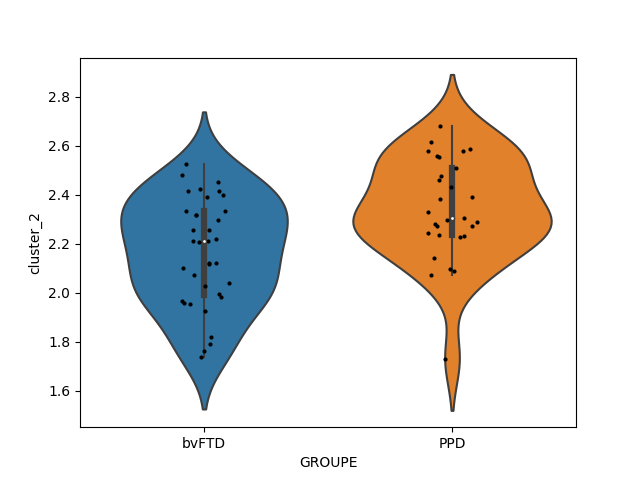

T-Test (oneside) : -3.335 and p_value = 0.001
******************************
SOUS_GROUPE, smooting à 25
***************************** 
Group comparison between bvFTD and BPD
fitting the model
Group comparison between bvFTD and ADS
fitting the model
/NAS/dumbo/protocoles/PSY_bvFTD/screenshots/sm_25/CTSurface_groupscomparison_bvFTD_vs_ADS_contrast1.jpg


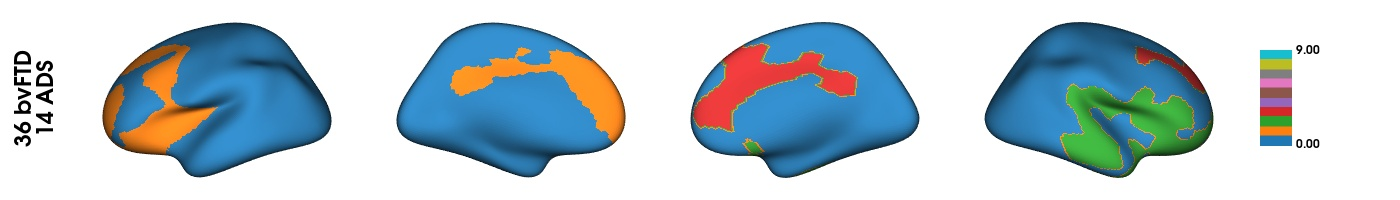

***** 
 clusters infos : 
***** 
     clusid  nverts    resels         P
0       1  1982.0  8.191754  0.000001
1       2  1800.0  6.580765  0.000008
2       3   829.0  3.895131  0.000391
***** 
 peaks infos : 
***** 
             t  clusid  vertid         P
0   4.748198       2   18687  0.008507
1   4.475285       1    3034  0.018684
2   4.389804       1    6750  0.023787
3   4.384392       1    1191  0.024149
4   3.882345       1    6944  0.094433
5   3.839179       3   16476  0.105708
6   3.769342       2   11374  0.126661
7   3.700813       2   15012  0.150953
8   3.698838       2   15014  0.151700
9   3.656942       3   14416  0.168606
10  3.633954       1    9126  0.178668
11  3.574520       1    7267  0.207025
13  3.562049       1    2659  0.213627
15  3.419856       1    4982  0.301789
16  3.386481       2   16291  0.326765
18  3.355494       1    8296  0.351807
19  3.353669       1    5909  0.353286
21  3.275203       1    1085  0.424305
22  3.273116       2   18269  0.426431
2

/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


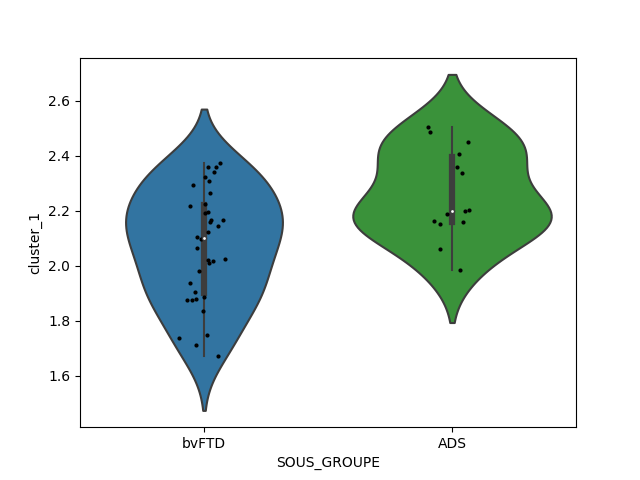

T-Test (oneside) : -3.447 and p_value = 0.002
  cluster_2 
/NAS/dumbo/protocoles/PSY_bvFTD/screenshots/sm_25/groups_compare_cluster_2_contrast1.png


/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


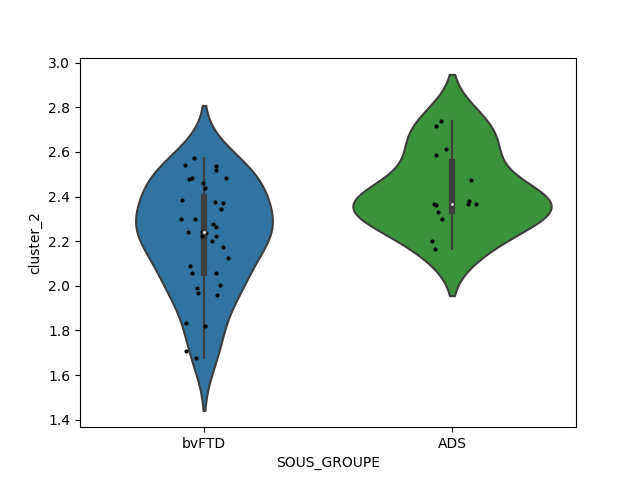

T-Test (oneside) : -3.321 and p_value = 0.002
  cluster_3 


/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


/NAS/dumbo/protocoles/PSY_bvFTD/screenshots/sm_25/groups_compare_cluster_3_contrast1.png


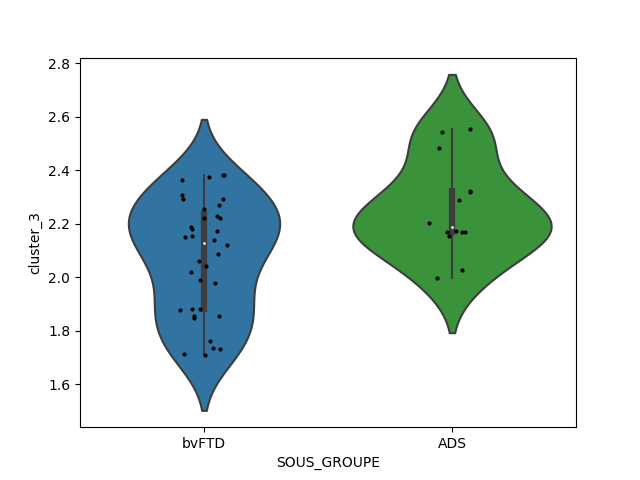

T-Test (oneside) : -3.073 and p_value = 0.005
Group comparison between BPD and ADS
fitting the model
******************************
GROUPE, smooting à 30
***************************** 
Group comparison between bvFTD and PPD
fitting the model
/NAS/dumbo/protocoles/PSY_bvFTD/screenshots/sm_30/CTSurface_groupscomparison_bvFTD_vs_PPD_contrast1.jpg


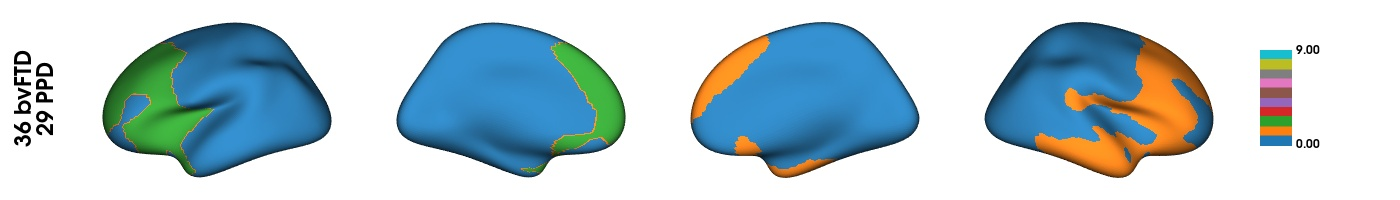

***** 
 clusters infos : 
***** 
     clusid  nverts    resels         P
0       1  2987.0  5.837304  0.000006
1       2  2099.0  4.466068  0.000058
***** 
 peaks infos : 
***** 
             t  clusid  vertid         P
0   4.069252       2    7586  0.025613
1   3.986342       2    3111  0.032584
2   3.725354       1   16432  0.067795
3   3.604730       2    1085  0.094022
4   3.603621       2    6558  0.094310
5   3.565976       2    8190  0.104239
6   3.550045       1   10840  0.108774
7   3.532289       1   11978  0.113885
8   3.518189       1   10965  0.118278
9   3.515507       1   14695  0.119114
10  3.513443       1   17664  0.119757
11  3.508385       2    5431  0.121333
12  3.463854       1   10924  0.136162
13  3.456458       1   13597  0.138777
14  3.447854       1   15693  0.141973
15  3.393583       1   20482  0.163095
16  3.264826       2    6420  0.225093
17  3.203294       2    5829  0.261360
18  3.194283       2    1510  0.267267
19  3.174475       1   15249  0.280251


/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


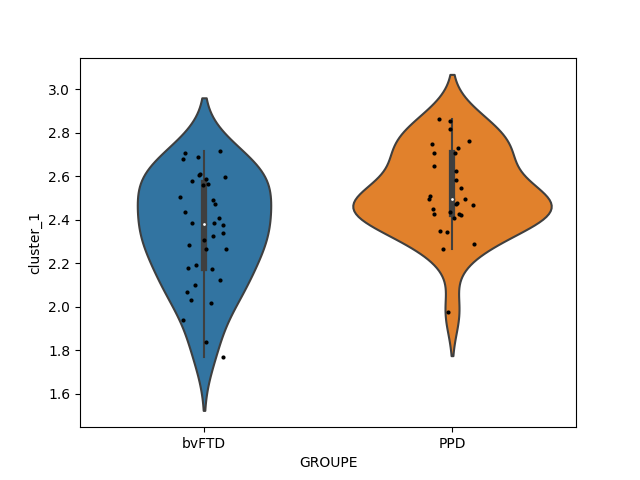

T-Test (oneside) : -3.193 and p_value = 0.002
  cluster_2 


/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


/NAS/dumbo/protocoles/PSY_bvFTD/screenshots/sm_30/groups_compare_cluster_2_contrast1.png


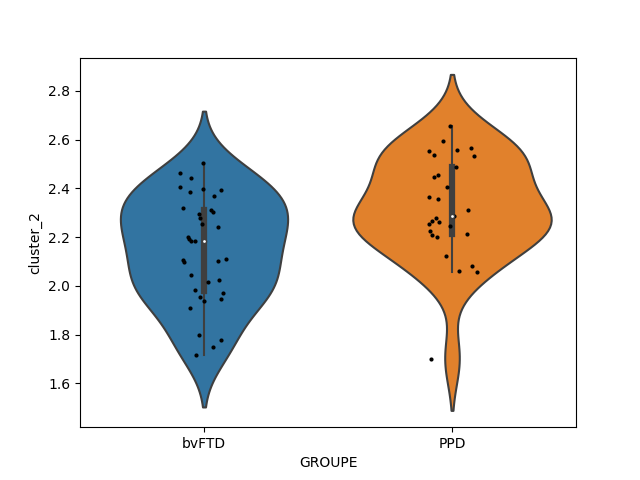

T-Test (oneside) : -3.243 and p_value = 0.002
******************************
SOUS_GROUPE, smooting à 30
***************************** 
Group comparison between bvFTD and BPD
fitting the model
Group comparison between bvFTD and ADS
fitting the model
/NAS/dumbo/protocoles/PSY_bvFTD/screenshots/sm_30/CTSurface_groupscomparison_bvFTD_vs_ADS_contrast1.jpg


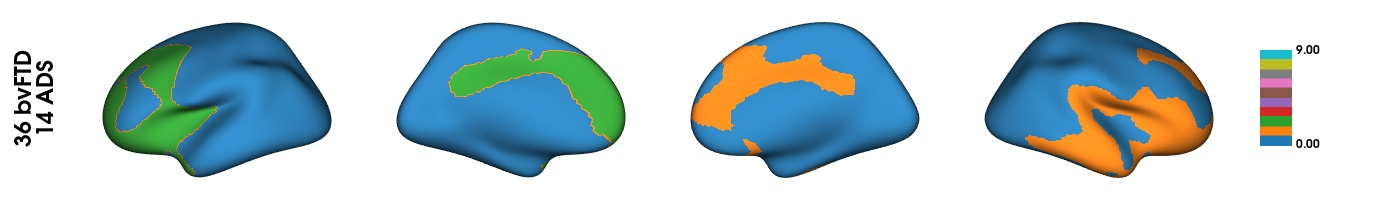

***** 
 clusters infos : 
***** 
     clusid  nverts    resels         P
0       1  2969.0  7.376399  0.000002
1       2  2324.0  5.955821  0.000011
***** 
 peaks infos : 
***** 
             t  clusid  vertid         P
0   4.460914       1   18687  0.012083
1   4.354322       2    3034  0.016329
2   4.225845       2    6752  0.023349
3   3.947632       1   10423  0.049582
4   3.734490       1   16492  0.086411
5   3.644755       1   16887  0.108471
6   3.614072       2    6944  0.117163
7   3.559870       1   19294  0.134158
8   3.470832       2    8239  0.166902
9   3.442241       2    4104  0.178901
10  3.341425       2    8295  0.227544
12  3.292363       1   14082  0.255391
14  3.234332       1   18270  0.292052
17  3.150845       1   16079  0.353307
18  3.136043       2    3604  0.365084
19  3.105011       1   11449  0.391381
20  3.103246       2    6559  0.392887
21  3.069532       1   12662  0.423350
22  2.938938       2    6416  0.561532
23  2.934109       2     950  0.567255


/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


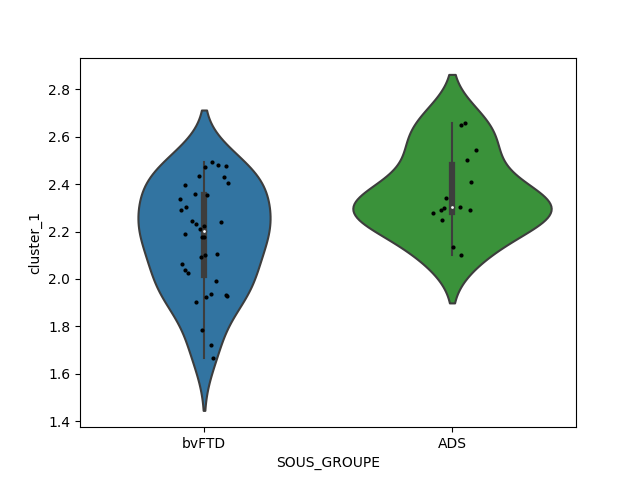

T-Test (oneside) : -3.216 and p_value = 0.003
  cluster_2 


/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


/NAS/dumbo/protocoles/PSY_bvFTD/screenshots/sm_30/groups_compare_cluster_2_contrast1.png


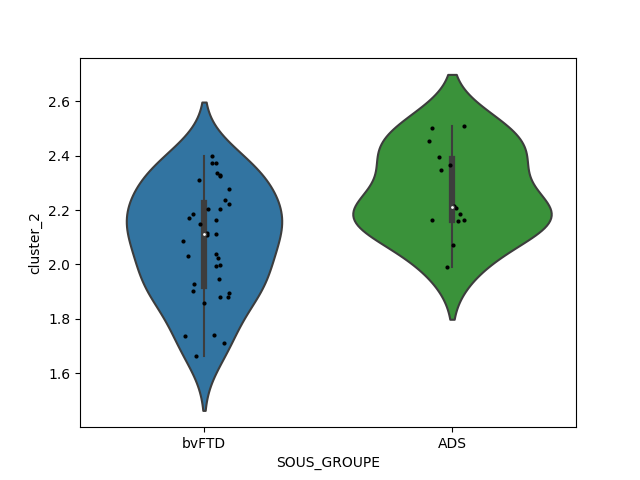

T-Test (oneside) : -3.369 and p_value = 0.002
Group comparison between BPD and ADS
fitting the model


In [23]:
reload(lbr)
pd.option_context('mode.use_inf_as_na', True)
for smoothing_fwhm in chain([11], range(15, 31, 5)):
    for groupUsed in ['GROUPE','SOUS_GROUPE'] :
        print(f"\033[1;31m******************************\n{groupUsed}, smooting à {smoothing_fwhm}\n***************************** \033[0m")  
        # Obtenez tous les couples possibles des valeurs uniques dans la colonne 'group'
        pairs = list(combinations(merged_data[groupUsed].dropna().unique(), 2))
        for pair in pairs: # Itérez sur tous les couples
            df_etude1_CT = pd.DataFrame(np.array(valCT[f"sm_{smoothing_fwhm}"]), index=merged_data.index)
            ssdf_CT = df_etude1_CT.loc[merged_data[groupUsed].isin([pair[0],pair[1]])]

            #Régression de l'age et du niveau d'education
            #lbr.regress_covar_func(df_etude1_CT.columns,var4Cov,ssdf_CT,merged_data.loc[merged_data[groupUsed].isin([pair[0],pair[1]])][var4Cov],True)

            ssdf_covar = merged_data.loc[ssdf_CT.index]

            # Construire le chemin du répertoire
            directory_path = os.path.join(STUDY_PATH, "screenshots", f"sm_{smoothing_fwhm}")

            # Créer le répertoire s'il n'existe pas
            os.makedirs(directory_path, exist_ok=True)
            lbr.grp_comp_surface_func(groupUsed,var4Cov,ssdf_covar,ssdf_CT,directory_path,MyPalette=palette)

La bibil à RORO loaded
******************************
Smooting à 15
***************************** 
FER
mFP
mFP_SocialContext
mFP_Mentalizing
mFP_Controls
Praxies
VOSP
TMT_B_A
Stroop_3-1
Empan_endroit
/NAS/dumbo/protocoles/PSY_bvFTD/screenshots/sm_15/correlation_CT_Empan_endroit.jpg


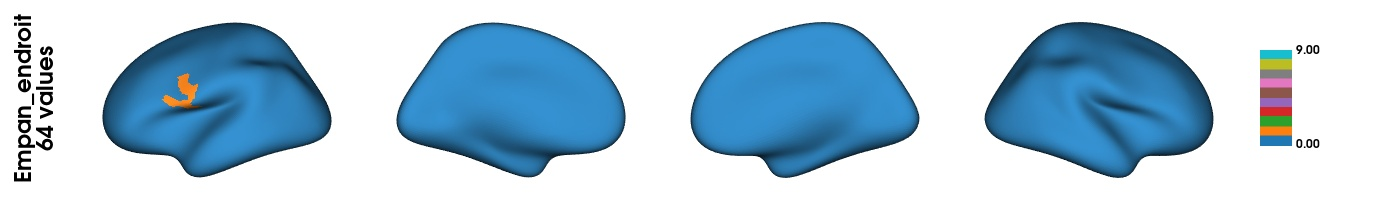

***** 
 clusters infos : 
***** 
     clusid  nverts    resels        P
0       1   164.0  2.546904  0.00007
***** 
 peaks infos : 
***** 
            t  vertid  clusid         P
0  4.668958    9197       1  0.025306
1  4.455162    7291       1  0.049261
2  4.062779    6399       1  0.159099
3  4.016036     993       1  0.182019
  cluster_1 
/NAS/dumbo/protocoles/PSY_bvFTD/screenshots/sm_15/corr_all_corr_cluster_1.png


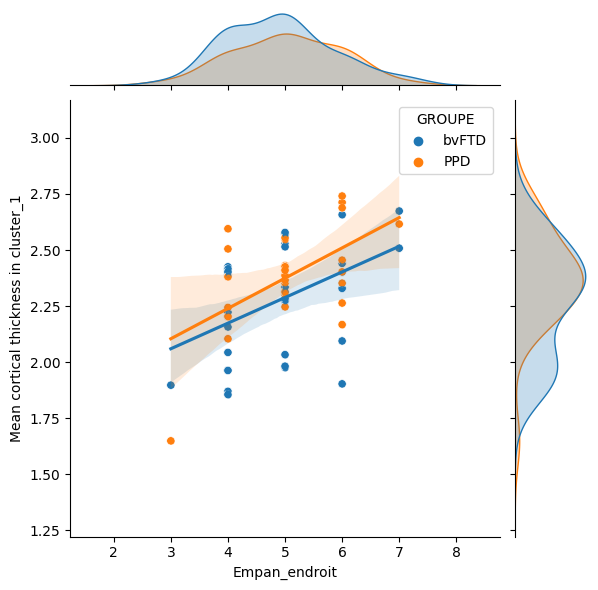

Coefficient de corrélation (Pearson) : 0.492 and p_value = 0.000
Coefficient de détermination aka Explained variance (R²) : 0.242
Empan_envers
CODE_WAIS
Denomination
FCSRT_RL
FCSRT_RT
TOP10
FER_EVC
FER_EVN
******************************
Smooting à 20
***************************** 
FER
mFP
mFP_SocialContext
mFP_Mentalizing
mFP_Controls
Praxies
VOSP
TMT_B_A
Stroop_3-1
Empan_endroit
Empan_envers
CODE_WAIS
Denomination
FCSRT_RL
FCSRT_RT
TOP10
FER_EVC
FER_EVN
******************************
Smooting à 25
***************************** 
FER
mFP
mFP_SocialContext
mFP_Mentalizing
mFP_Controls
Praxies
VOSP
TMT_B_A
Stroop_3-1
Empan_endroit
Empan_envers
CODE_WAIS
Denomination
FCSRT_RL
FCSRT_RT
TOP10
FER_EVC
FER_EVN
******************************
Smooting à 30
***************************** 
FER
mFP
mFP_SocialContext
mFP_Mentalizing
mFP_Controls
Praxies
VOSP
TMT_B_A
Stroop_3-1
Empan_endroit
Empan_envers
CODE_WAIS
Denomination
FCSRT_RL
FCSRT_RT
TOP10
FER_EVC
FER_EVN


<Figure size 640x480 with 0 Axes>

In [18]:
import warnings
warnings.filterwarnings('ignore')
reload(lbr)
plt.tight_layout()
for smoothing_fwhm in chain([11], range(15, 31, 5)):
    print(f"\033[1;31m******************************\nSmooting à {smoothing_fwhm}\n***************************** \033[0m")  
    for varCorr in var4Corr:
        print(varCorr)
        df_etude1_CT = pd.DataFrame(np.array(valCT[f"sm_{smoothing_fwhm}"]), index=merged_data.index)
        # Construire le chemin du répertoire
        directory_path = os.path.join(STUDY_PATH, "screenshots", f"sm_{smoothing_fwhm}")

        # Créer le répertoire s'il n'existe pas
        os.makedirs(directory_path, exist_ok=True)
        lbr.corr_surface_var_func([varCorr],var4Cov,merged_data,df_etude1_CT,directory_path,MyPalette=palette)

In [16]:
!jupyter nbconvert --no-input --to pdf DFTvc_MB_etude1.ipynb 

[NbConvertApp] Converting notebook DFTvc_MB_etude1.ipynb to pdf
/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/nbconvert/filters/datatypefilter.py:41: UserWarning: Your element with mimetype(s) dict_keys(['application/javascript', 'application/vnd.holoviews_load.v0+json']) is not able to be represented.
  warn(
/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/nbconvert/filters/datatypefilter.py:41: UserWarning: Your element with mimetype(s) dict_keys(['text/html']) is not able to be represented.
  warn(
/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/nbconvert/filters/datatypefilter.py:41: UserWarning: Your element with mimetype(s) dict_keys(['application/vnd.holoviews_exec.v0+json', 'text/html']) is not able to be represented.
  warn(
[NbConvertApp] Support files will be in DFTvc_MB_etude1_files/
[NbConvertApp] Making directory ./DFTvc_MB_etude1_files
[NbConvertApp] Making directory ./DFTvc_MB_etude1_files
[NbConvertApp] Making directory ./DFTvc_MB_

# Autre design matriX

In [ ]:
reload(lbr)

for groupUsed in ['GROUPE','SOUS_GROUPE'] :
    print(f"\033[1;31m******************************\n{groupUsed}\n***************************** \033[0m")  
    # Obtenez tous les couples possibles des valeurs uniques dans la colonne 'group'
    pairs = list(combinations(merged_data[groupUsed].dropna().unique(), 2))
    for pair in pairs: # Itérez sur tous les couples
        
        #ssdf_covar = df_etude1_scoreAndCov.loc[df_etude1_scoreAndCov[groupUsed].isin([pair[0],pair[1]])]
        #ssdf_CT = df_etude1_CT.loc[df_etude1_scoreAndCov[groupUsed].isin([pair[0],pair[1]])]
        #print(ssdf.shape,ssdf[col_list].dropna(axis=0).shape,ssdf[col_list].dropna(axis=1).shape)
    
        ssdf_CT = df_etude1_CT.loc[merged_data[groupUsed].isin([pair[0],pair[1]])]
        ssdf_covar = merged_data.loc[ssdf_CT.index]
   
        contrast_group = (ssdf_covar[groupUsed] == pair[0]).astype(int) - (ssdf_covar[groupUsed] == pair[1]).astype(int)
        term_group = FixedEffect(ssdf_covar[groupUsed])
        
        #model_group = term_group
        #model_group_age_educ=model_group
        
        #for varc in var4Cov:
        #    model_group_age_educ = model_group_age_educ + FixedEffect(ssdf_covar[varc])

        term_age = FixedEffect(ssdf_covar[var4Cov[0]])
        term_educ = FixedEffect(ssdf_covar[var4Cov[1]])
        #term_subject = MixedEffect(ssdf_covar["IDENTIFIANT"])
    
        #Créer le modèle avec covariables
        model_group_age_educ = term_group + term_age + term_educ + term_age * term_educ #+ term_subject
    
        slm_group = SLM(
            model_group_age_educ,
            contrast_group,
            surf=pial_combined,
            mask=mask,
            correction=["fdr", "rft"],
            two_tailed=True,
            cluster_threshold=0.01,
        )
        
        slm_group.fit(ssdf_CT.values)
        
        cp = [np.copy(slm_group.P["pval"]["C"])]
        [np.place(x, np.logical_or(x > 0.05, ~mask), np.nan) for x in cp]
        
        threshold_p=0.01
        threshold_size=50
        for contrast in [0,1]:           
            filtered_df = slm_group.P['clus'][contrast][(slm_group.P['clus'][contrast]['nverts'] > threshold_size) & (slm_group.P['clus'][contrast]['P'] < threshold_p)]
            if len(filtered_df)>0 :
                figure_title=os.path.join(STUDY_PATH,"screenshots",f"CTSurface_groupscomparison_{pair[0]}_vs_{pair[1]}_contrast{contrast}.jpg")
                labText=f"{np.sum(ssdf_covar[groupUsed] == pair[0])} {pair[0]}\n{np.sum(ssdf_covar[groupUsed] == pair[1])} {pair[1]}"
                max_cluster_nb=np.max(filtered_df["clusid"].values)
                test = np.copy(slm_group.P["clusid"][contrast].reshape(-1))
                test = np.where(test > max_cluster_nb, 0, test)
                plot_hemispheres(inflated_left, inflated_right,test,label_text=[labText],color_range=(0,9),color_bar=True,
                    cmap="tab10", embed_nb=True, size=(1400, 200),zoom=1.45, nan_color=(0.7, 0.7, 0.7, 1),
                    cb__labelTextProperty={"fontSize": 12},transparent_bg=False,screenshot=True, offscreen=False,filename=figure_title)
                display(Image(filename=figure_title))
                print(f"{lbr.BLUE}***** \n clusters infos : \n***** \n {lbr.RESET} {filtered_df}")
                df_tmp=slm_group.P['peak'][contrast]
                print(f"{lbr.BLUE}***** \n peaks infos : \n***** \n {lbr.RESET} {df_tmp[(df_tmp['clusid'] <= max_cluster_nb)]}")
                for clu in filtered_df["clusid"].values :
                    df_copy=ssdf_covar.loc[:,[groupUsed]+var4Cov]
                    inds=np.where(slm_group.P['clusid'][contrast]==clu)[1]
                    name=f"cluster_{str(clu)}"
                    print(f'{lbr.ansi_colors[clu]} {lbr.BOLD} {name} {lbr.RESET}')
                    df_copy[name] = np.mean(ssdf_CT.values[:,inds],1)
                    plt.figure()
                    ax = plt.gca()
                    lbr.regress_covar_func([name],var4Cov,df_copy,df_copy,False)
                    # Faire une copie du dictionnaire palette
                    palette_copy = palette.copy()

                    # Obtenir les groupes uniques présents dans df_copy
                    groups_present = df_copy[groupUsed].unique()

                    # Supprimer les groupes non présents dans df_copy de la copie du dictionnaire palette
                    palette_copy = {group: color for group, color in palette_copy.items() if group in groups_present}

                    sns.stripplot(df_copy,y=name,x=groupUsed,size=3,color="black", order=palette_copy.keys())
                    sns.violinplot(df_copy,y=name,x=groupUsed, palette=palette_copy,order=palette_copy.keys())
                    figure_title=os.path.join(STUDY_PATH,f"groups_compare_{name}_contrast{contrast}.png")
                    plt.savefig(figure_title)
                    plt.close()
                    display(Image(filename=figure_title))

                    # Effectuer un test t avec Pingouin
                    ttest_results = pg.ttest(df_copy[df_copy[groupUsed] == pair[0]][name],df_copy[df_copy[groupUsed] == pair[1]][name])
                    tvalue=ttest_results["T"].values[0]
                    pvalue=ttest_results["p-val"].values[0]
                    print(f"T-Test (oneside) : {tvalue:.3f} and p_value = {pvalue:.3f}")